In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
import os
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
import tensorflow as tf
import glob
import category_encoders as ce
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV

from tqdm import tqdm

import multiprocessing
import time

In [6]:
image_size = 40

In [4]:
train_files = glob.glob('../input/train/normalized/*/*.ppm')  # iterate through all subfolders

def read_image_train(filename):
    train_images = []
    
    image = cv2.imread(filename)
    image = cv2.resize(image, (image_size, image_size))

    train_images.append(image)
    return train_images

def read_images_train(filenames):
    with multiprocessing.pool.Pool(8) as pool:
        return pool.map(read_image_train, filenames)
 
start_time = time.time()

train_labels = [int(filename.split('/')[4]) for filename in train_files]
train_images = read_images_train(train_files)

print(f"{time.time() - start_time} seconds")

120.15705013275146 seconds


In [5]:
test_files = glob.glob('../input/test/normalized/*/*.ppm')  # iterate through all subfolders

def read_image_test(filename):
    test_images = []
    
    image = cv2.imread(filename)
    image = cv2.resize(image, (image_size, image_size))

    test_images.append(image)
    return test_images

def read_images_test(filenames):
    with multiprocessing.pool.Pool(8) as pool:
        return pool.map(read_image_test, filenames)
 
start_time = time.time()

test_labels = [int(filename.split('/')[4]) for filename in test_files]
test_images = read_images_test(test_files)

print(f"{time.time() - start_time} seconds")

39.761120080947876 seconds


In [6]:
train_images = [img[0] for img in train_images]
test_images = [img[0] for img in test_images]

In [7]:
train_images = [image/255 for image in train_images]
train_images = np.array(train_images)

In [8]:
test_images = [image/255 for image in test_images]
test_images = np.array(test_images)

In [9]:
y_train = pd.DataFrame(train_labels, columns=['label'])
encoder = ce.OneHotEncoder(cols=['label'], use_cat_names=True,
                        return_df=False)
print(y_train['label'].nunique())
y_train = encoder.fit_transform(y_train)
y_train

102


/home/therandomtroll/miniconda3/envs/tf/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [10]:
y_test = pd.DataFrame(test_labels, columns=['label'])
print(y_test['label'].nunique())
y_test = encoder.fit_transform(y_test)
y_test

102


/home/therandomtroll/miniconda3/envs/tf/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [5]:
loss_func, act_func, out_layer = 'categorical_crossentropy', 'softmax', 102

In [7]:
n_filters = 256
kernel_s = 5
mp = 2
dense_l = 128
batch = 512
drop = 0.4
name_out = f'models/{image_size}_{n_filters}_{kernel_s}_{mp}_{dense_l}_{drop}_3_{batch}_bg'
name_out

'models/40_256_5_2_128_0.4_3_512_bg'

In [8]:
#Instantiate model
cnn = Sequential()

#convolution layers
cnn.add(Conv2D(filters = n_filters,       #number of filters to use
              kernel_size = (kernel_s,kernel_s),   #dimensions of the filters
              activation = 'relu',    #activation function
              input_shape = (image_size, image_size,3)))  #shape of image
cnn.add(MaxPooling2D(pool_size = (mp,mp))) 
cnn.add(Dropout(drop))
cnn.add(Conv2D(n_filters, kernel_size = (kernel_s,kernel_s), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (mp,mp)))
cnn.add(Dropout(drop))
cnn.add(Conv2D(n_filters, kernel_size = (kernel_s,kernel_s), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (mp,mp)))
cnn.add(Dropout(drop))
cnn.add(Flatten())

#dense layers
cnn.add(Dense(dense_l, activation = 'relu'))
cnn.add(Dropout(drop))
# cnn.add(Dense(48, activation = 'relu'))

# Example lines of the regularization methods tried
# cnn.add(Dropout(0.2))
# cnn.add(BatchNormalization())
# ,kernel_regularizer=l2(0.01)
# cnn.add(Dropout(0.3))

#finalize things
cnn.add(Dense(out_layer, activation = act_func))
cnn.compile(loss = loss_func,
           optimizer = 'adam',
           metrics = ['accuracy'])
cnn.summary()

2023-01-16 00:06:02.925863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-16 00:06:02.970017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-16 00:06:02.970063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-16 00:06:02.971059: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 36, 256)       19456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 18, 18, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       1638656   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 256)         0

In [15]:
!pip install ann_visualizer graphviz visualkeras

/bin/bash: /home/therandomtroll/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.2/993.2 kB 24.1 MB/s eta 0:00:0000:01


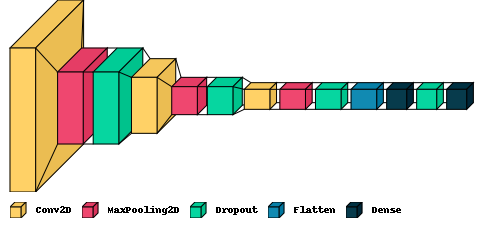

In [17]:

import visualkeras
from PIL import ImageFont
visualkeras.layered_view(cnn, legend=True)

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1,restore_best_weights=True, mode='auto')

In [15]:
#Perform the fit, epochs set to 1000 since early stop being used. 
tf.random.set_seed(42)
history_bw = cnn.fit(train_images, y_train, validation_data = (test_images, y_test),
                 batch_size = batch,
                 epochs = 1000,
                 verbose = 1,
                 callbacks = [early_stop]
)

Epoch 1/1000


2023-01-11 18:45:49.868729: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-01-11 18:45:50.850593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-11 18:45:52.946239: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-11 18:45:55.914911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-11 18:45:55.991035: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc96fe54670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-11 18:45:55.991093: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor devi

110/111 [============================>.] - ETA: 0s - loss: 2.5904 - accuracy: 0.3835

2023-01-11 18:46:09.465586: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-11 18:46:09.465656: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



111/111 [==============================] - ETA: 0s - loss: 2.5802 - accuracy: 0.3855

2023-01-11 18:46:11.412289: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-11 18:46:11.412390: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.74GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-11 18:46:19.131273: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-11 18:46:19.131332: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

111/111 [==============================] - 32s 196ms/step - loss: 2.5802 - accuracy: 0.3855 - val_loss: 0.8561 - val_accuracy: 0.8045
Epoch 2/1000
111/111 [==============================] - 11s 102ms/step - loss: 0.8239 - accuracy: 0.7837 - val_loss: 0.3651 - val_accuracy: 0.9141
Epoch 3/1000
111/111 [==============================] - 11s 100ms/step - loss: 0.4881 - accuracy: 0.8703 - val_loss: 0.2514 - val_accuracy: 0.9399
Epoch 4/1000
111/111 [==============================] - 10s 92ms/step - loss: 0.3673 - accuracy: 0.9026 - val_loss: 0.1957 - val_accuracy: 0.9521
Epoch 5/1000
111/111 [==============================] - 10s 92ms/step - loss: 0.2979 - accuracy: 0.9190 - val_loss: 0.1631 - val_accuracy: 0.9593
Epoch 6/1000
111/111 [==============================] - 10s 95ms/step - loss: 0.2507 - accuracy: 0.9311 - val_loss: 0.1441 - val_accuracy: 0.9648
Epoch 7/1000
111/111 [==============================] - 10s 93ms/step - loss: 0.2194 - accuracy: 0.9387 - val_loss: 0.1262 - val_accur

In [2]:
%load_ext tensorboard
import tensorboard
print("TensorBoard version: ", tensorboard.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TensorBoard version:  2.8.0


In [16]:
#Function for plotting CNN history
def Loss_Acc_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,8))
    fig.suptitle("Model Performance", fontsize = 25, fontweight = 'bold')

    ax1.plot(range(1, len(acc) + 1), acc,  color='#185fad')
    ax1.plot(range(1, len(val_acc) + 1), val_acc, color='orange')
    ax1.set_title('History of Accuracy by Epoch', fontsize=20)
    ax1.set_xlabel('Epoch', fontsize=18)
    ax1.set_ylabel('Accuracy', fontsize=18)
    ax1.legend(['training', 'validation'], fontsize=18)


    ax2.plot(range(1, len(loss) + 1), loss, color='#185fad')
    ax2.plot(range(1, len(val_loss) + 1), val_loss, color='orange')
    ax2.set_title('History of Loss by Epoch', fontsize=20)
    ax2.set_xlabel('Epoch', fontsize=18)
    ax2.set_ylabel('Binary Crossentropy (Loss)', fontsize=18)
    ax2.legend(['training', 'validation'], fontsize=18)
    
    plt.tight_layout()
    plt.show()
    

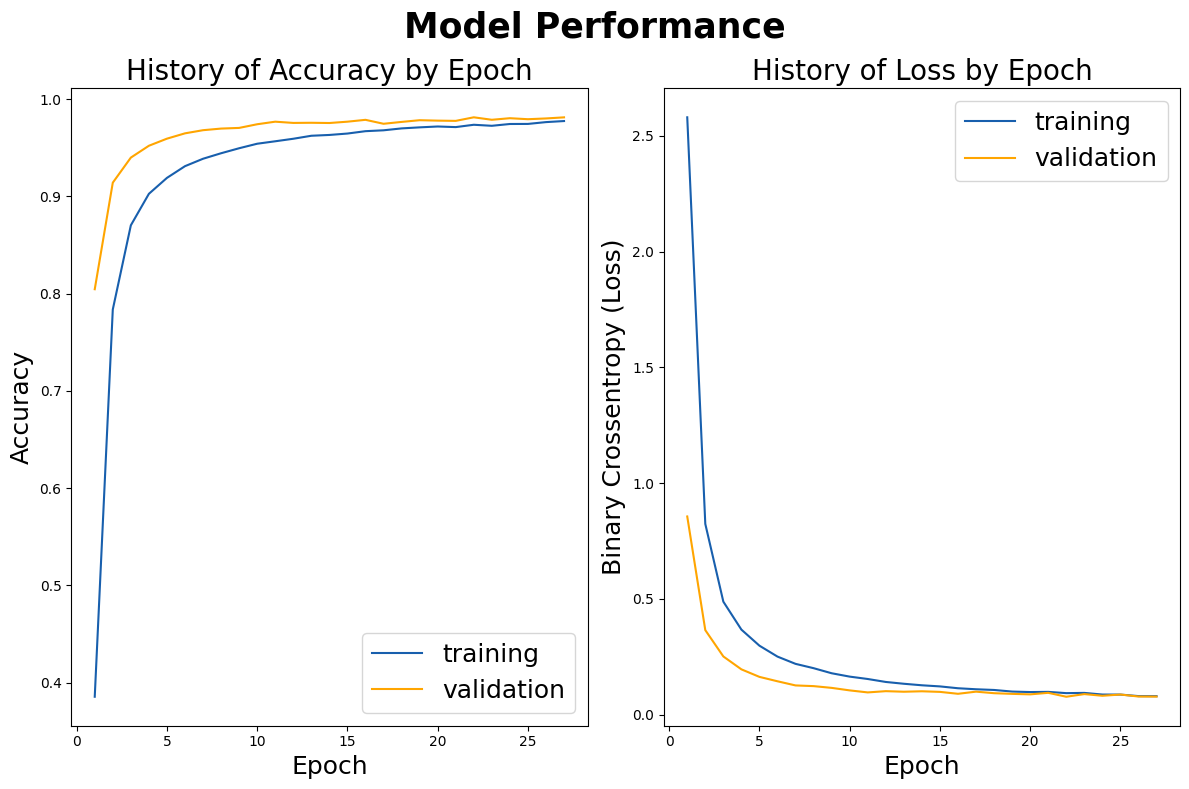

In [17]:
#run the plot for the history
Loss_Acc_Plot(history_bw.history['accuracy'],history_bw.history['val_accuracy'],
               history_bw.history['loss'],history_bw.history['val_loss'])

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [35]:
preds = cnn.predict(test_images).round(0)
preds_recode = pd.DataFrame(preds,columns = list(set(test_labels))).idxmax(1)
cm = confusion_matrix(test_labels, preds_recode,normalize='true')

639/639 [==============================] - 2s 3ms/step


In [36]:
cm = np.where(cm == 0, np.NaN, cm)

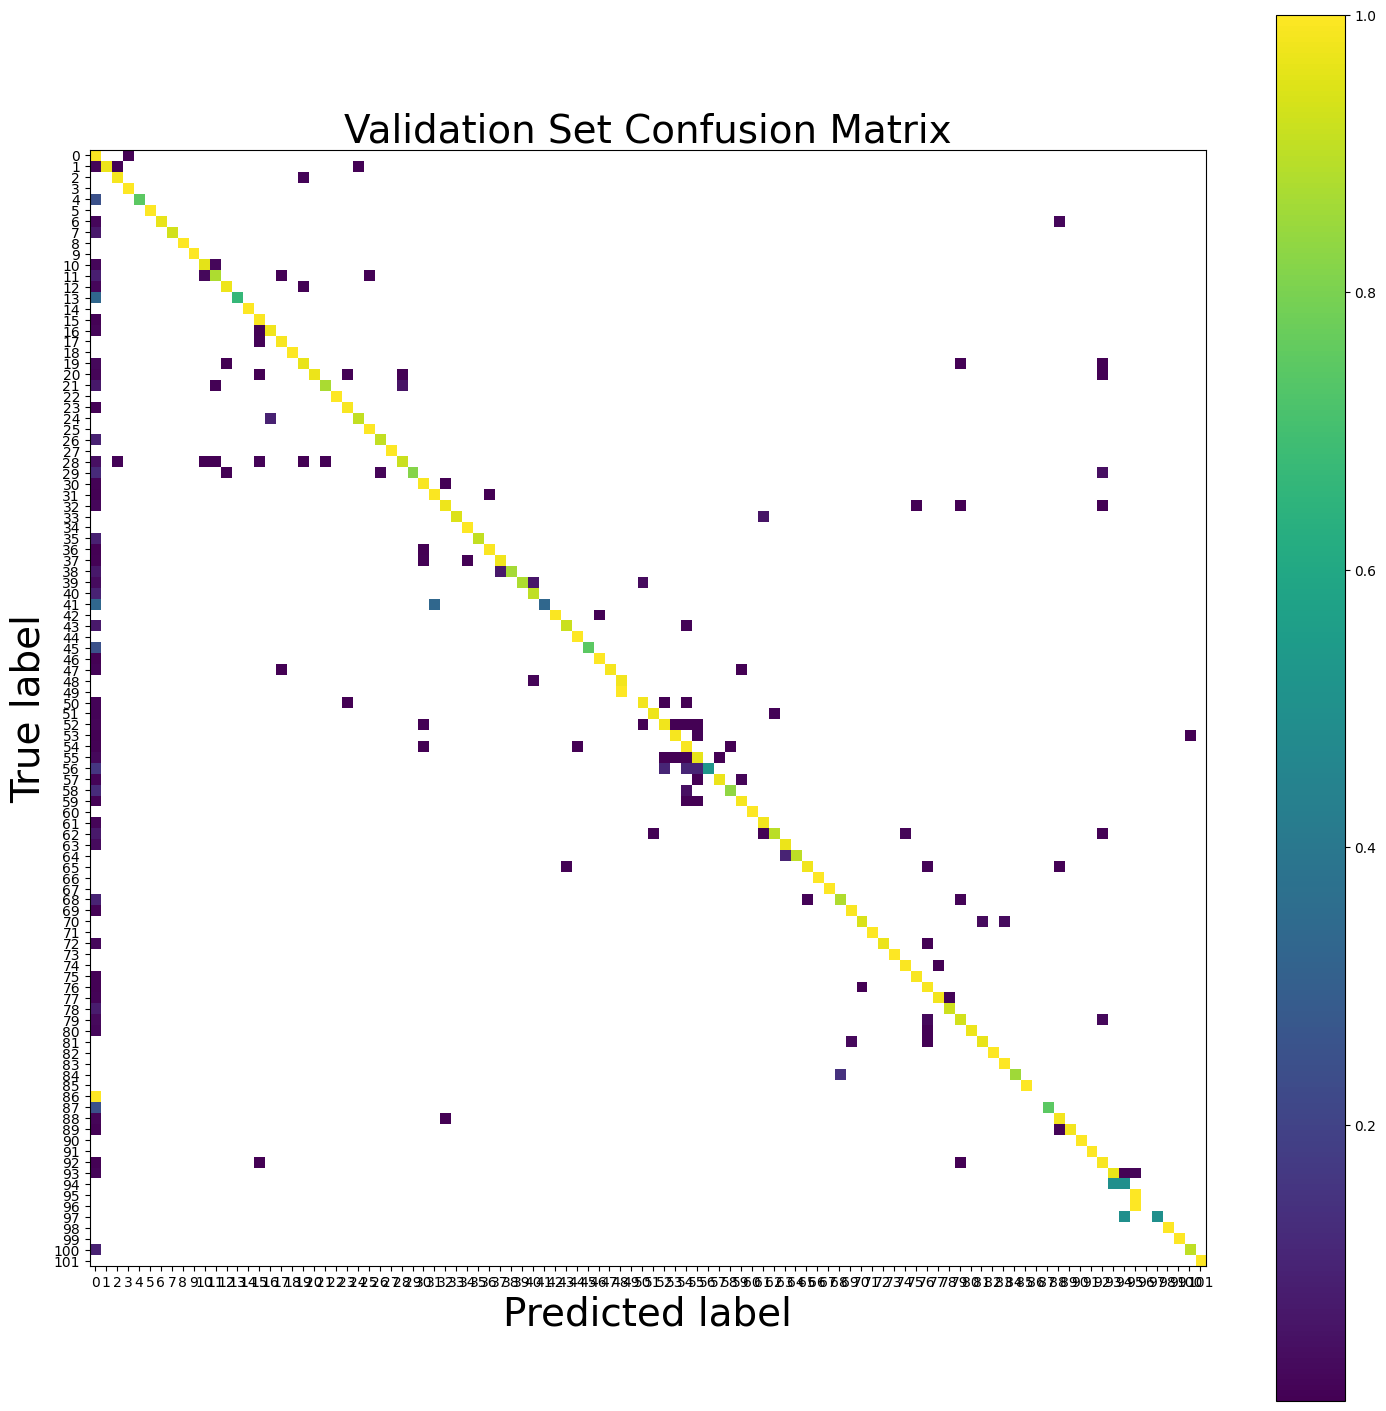

In [37]:
fig, ax = plt.subplots(figsize=(18,18))
ax.set_title('Validation Set Confusion Matrix',fontsize = 28)
ax.set_xlabel('Predicted Sign',fontsize=28)
ax.set_ylabel('True Sign',fontsize = 28)
ConfusionMatrixDisplay(cm).plot(ax=ax,include_values=False)

In [45]:
classes = pd.read_csv('../classes.csv')
classes

category                      object
subcategory                   object
descriptive_name              object
vienna_convention_category    object
european_class                 int64
dtype: object

In [53]:
classes.loc[classes['european_class'] == 1].iloc[0].descriptive_name

'Right bend'

In [63]:
import random
random_numbers = [random.randint(0,len(test_images)) for _ in range(200)]

21 21


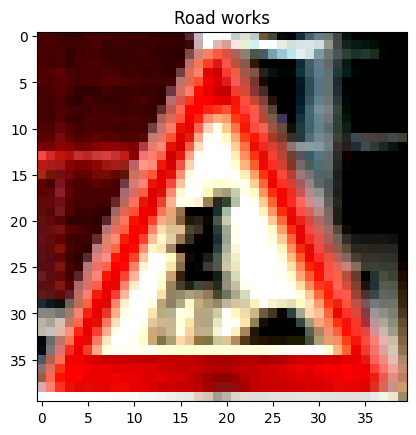

36 36


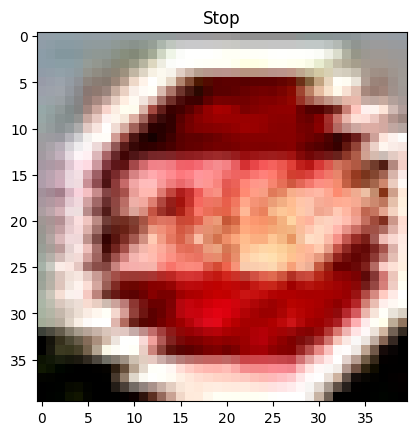

68 68


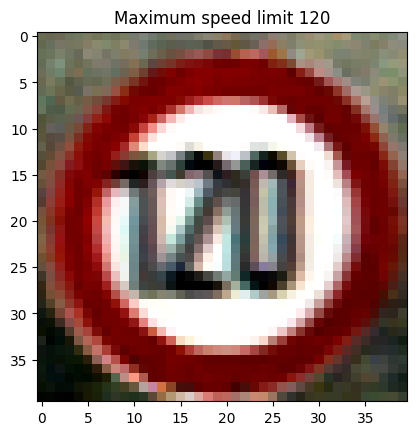

35 35


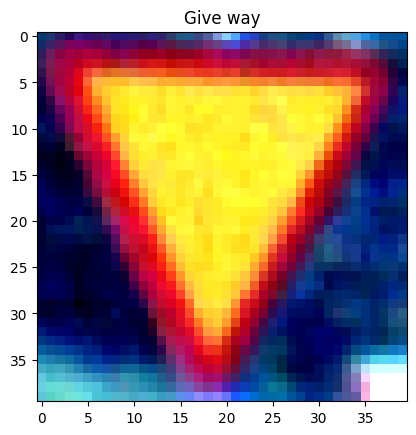

21 21


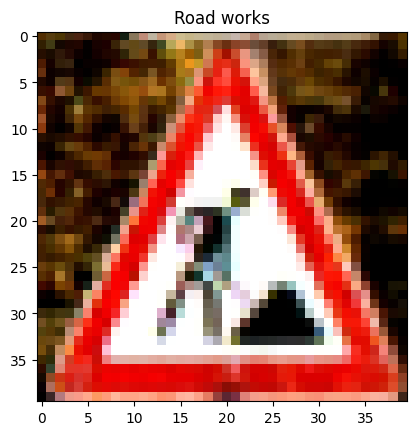

21 21


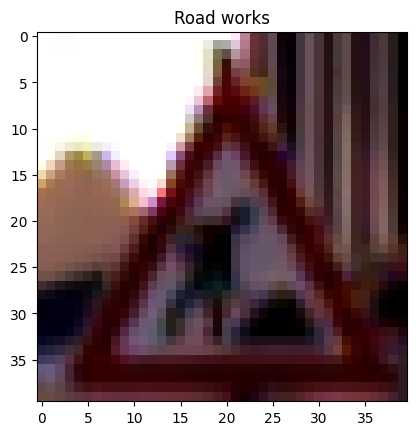

62 62


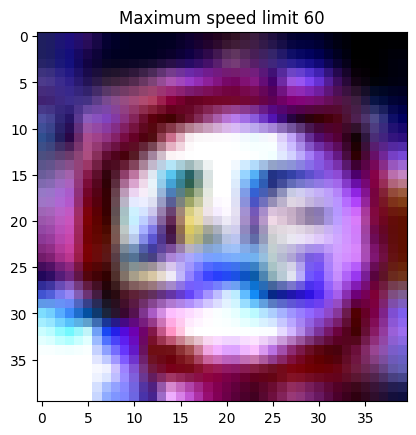

63 63


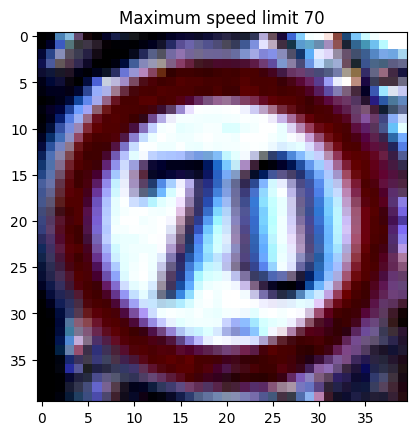

54 54


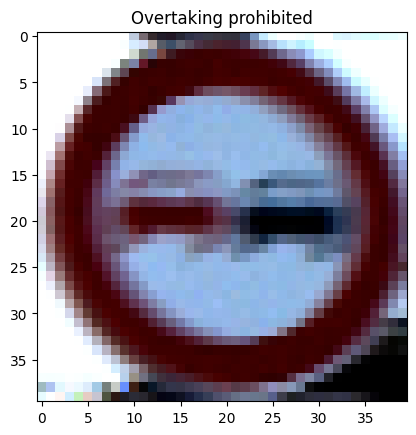

68 68


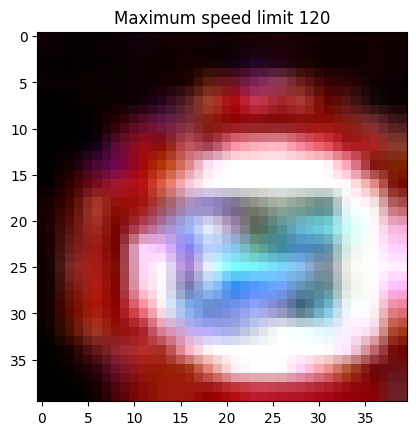

17 17


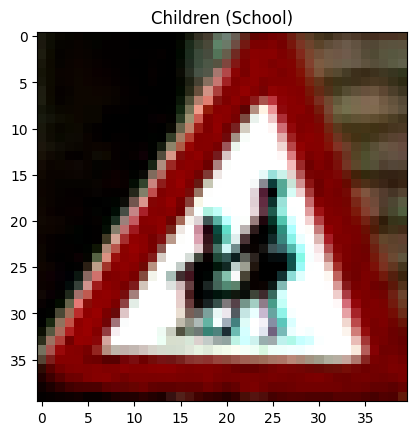

35 35


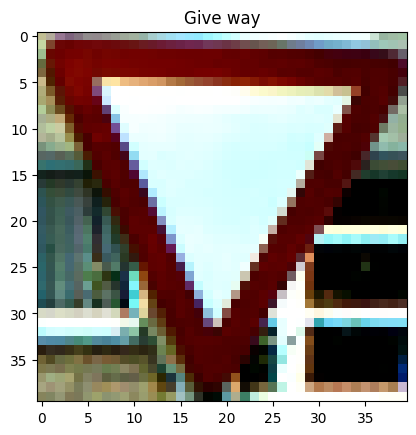

17 17


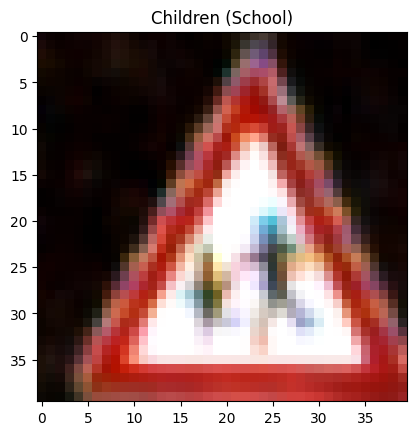

109 109


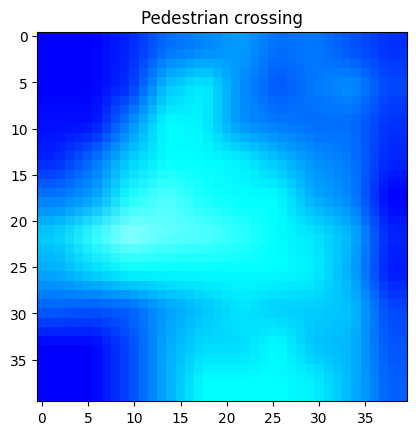

59 59


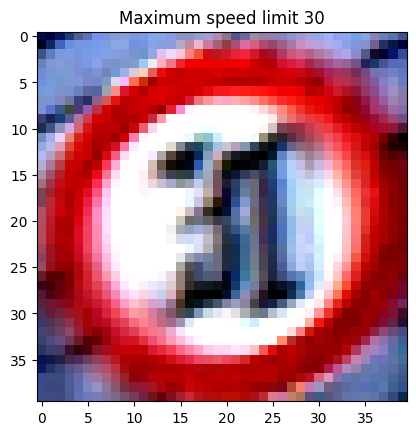

64 64


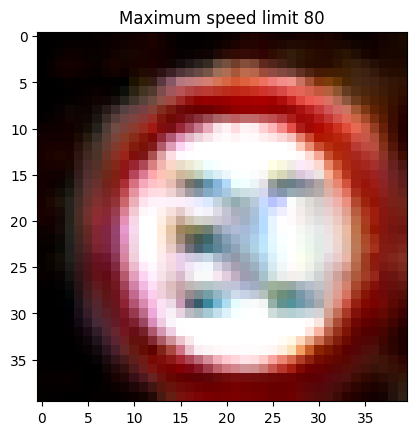

64 64


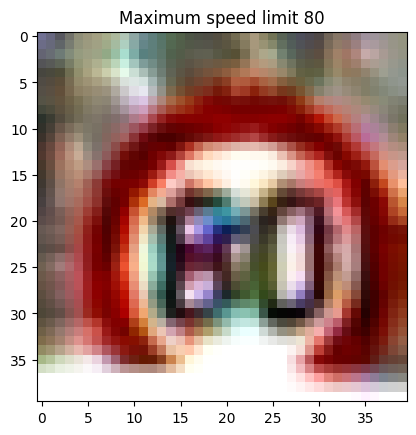

3 3


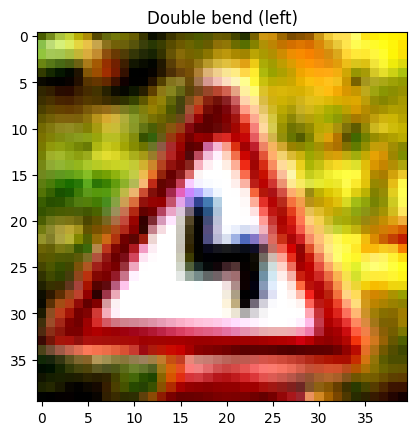

55 55


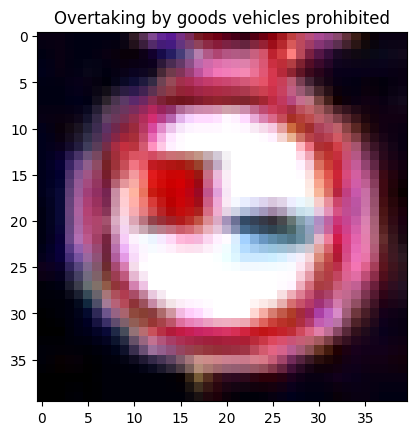

109 109


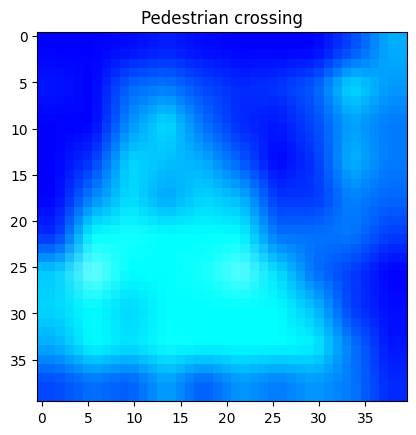

41 41


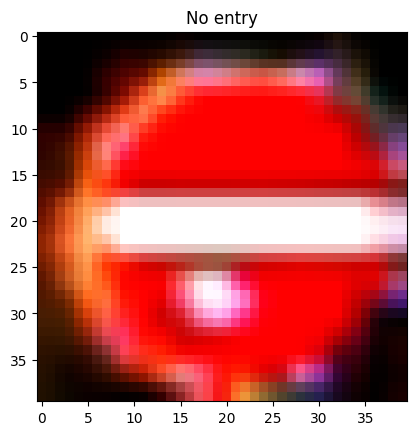

109 109


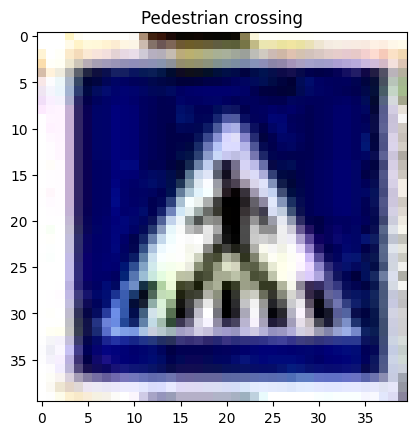

41 41


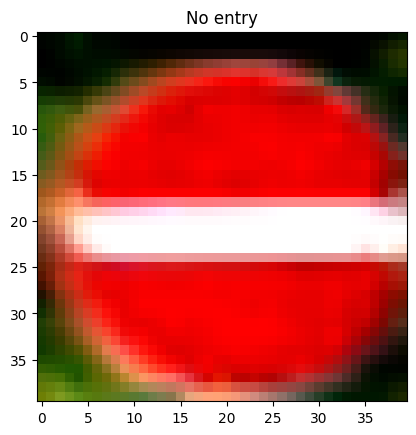

17 17


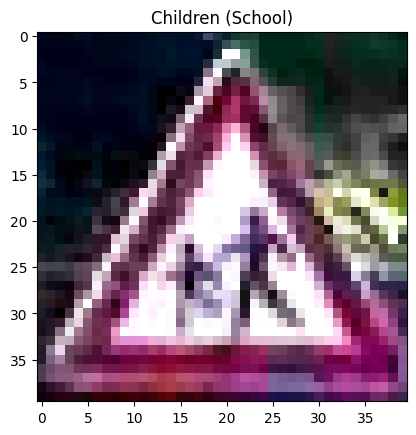

55 55


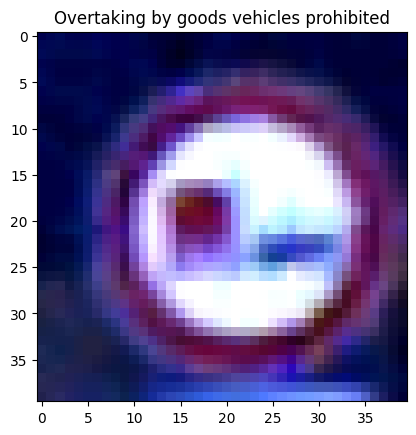

21 21


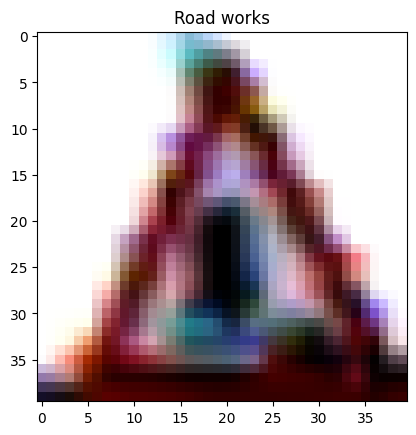

17 17


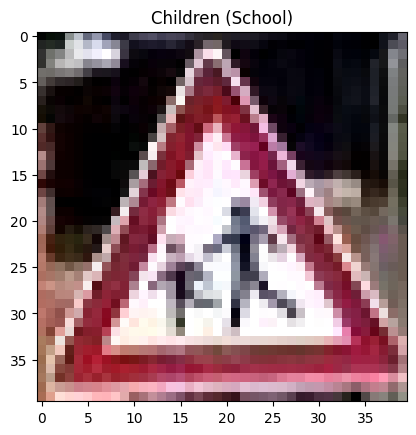

37 37


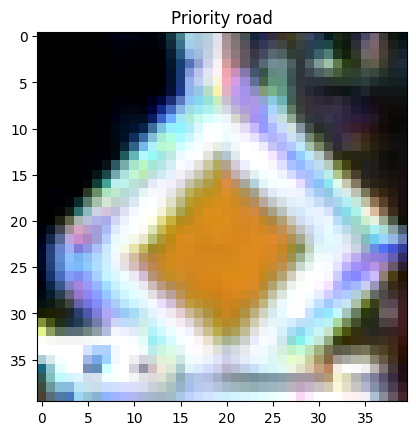

68 68


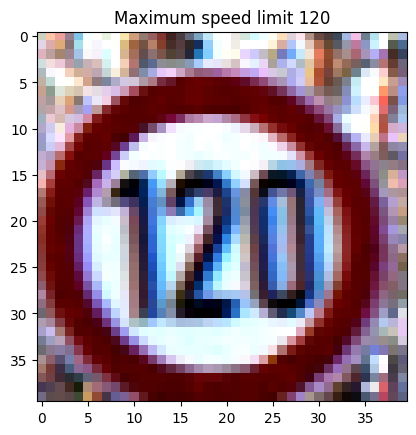

107 107


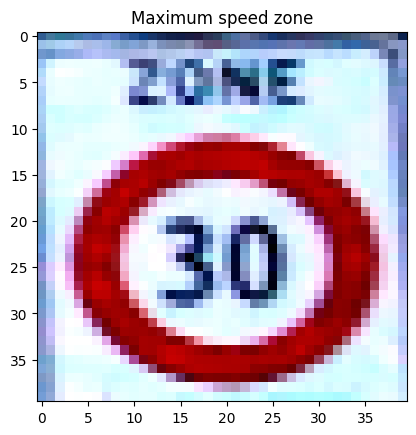

110 110


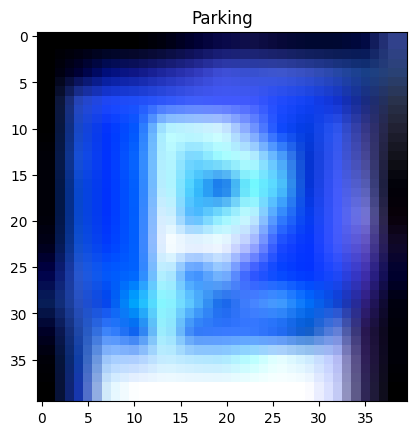

87 87


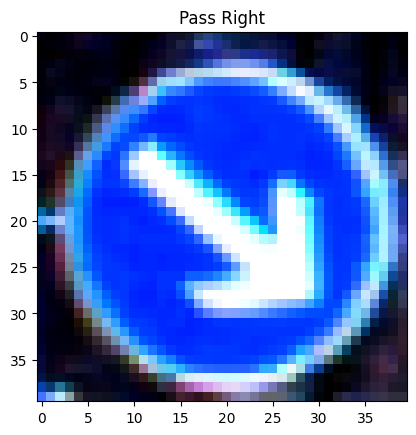

2 2


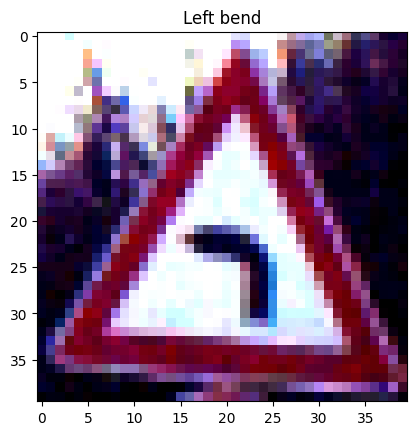

64 64


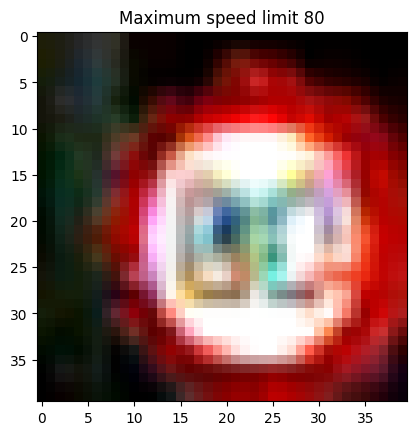

23 23


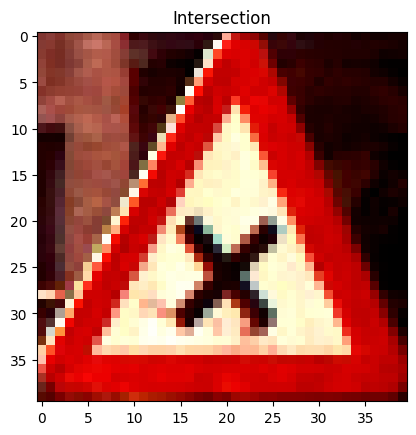

37 37


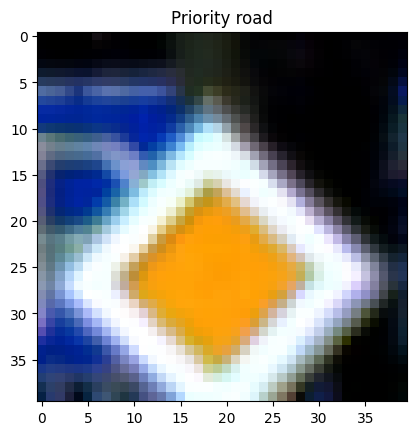

51 51


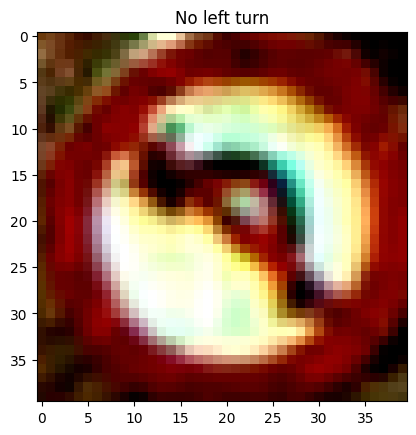

42 42


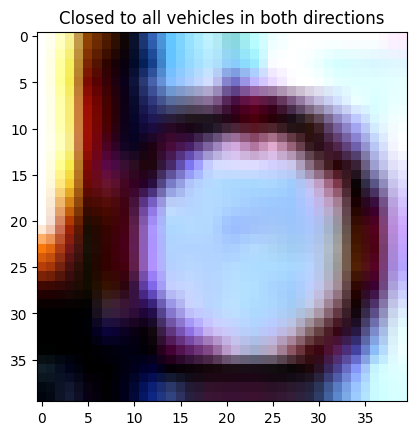

41 41


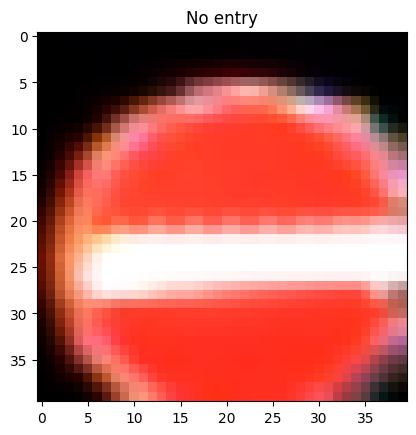

63 63


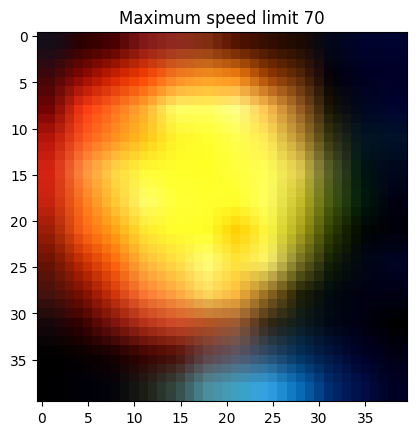

42 42


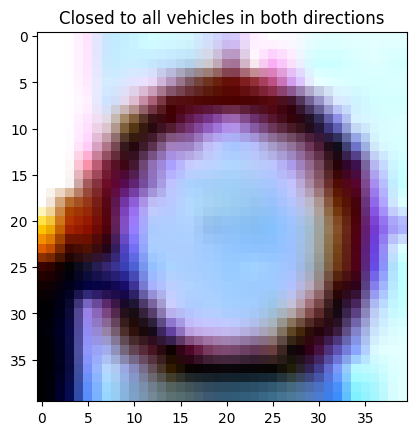

21 21


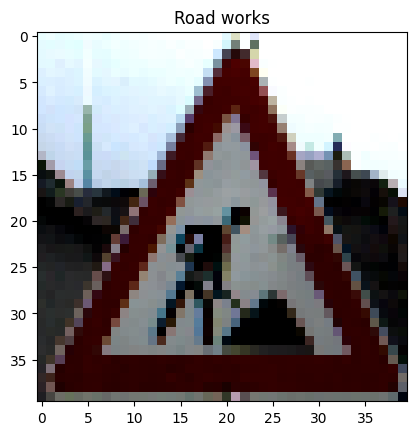

63 63


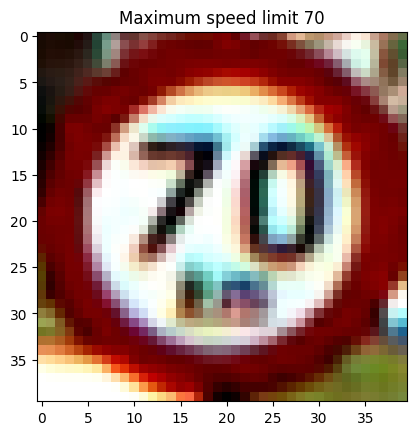

16 16


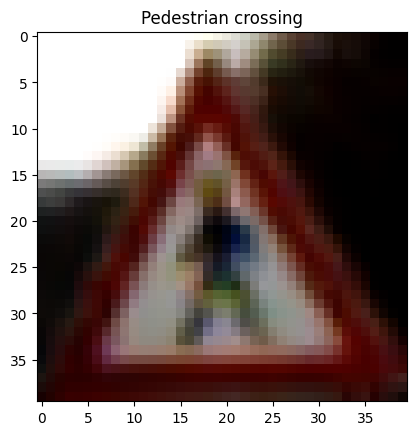

22 22


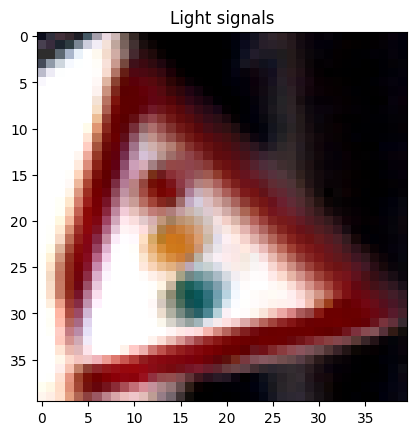

73 73


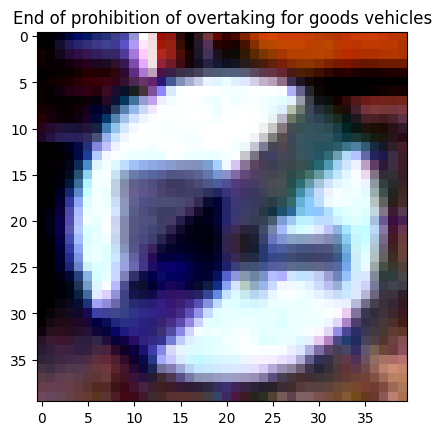

62 62


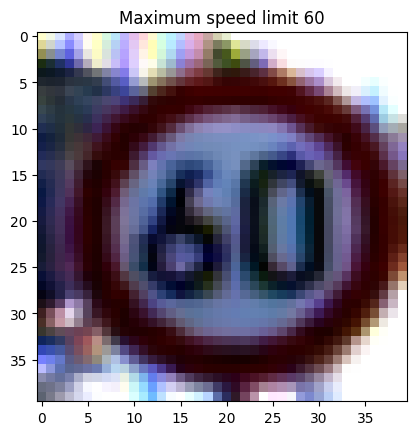

64 64


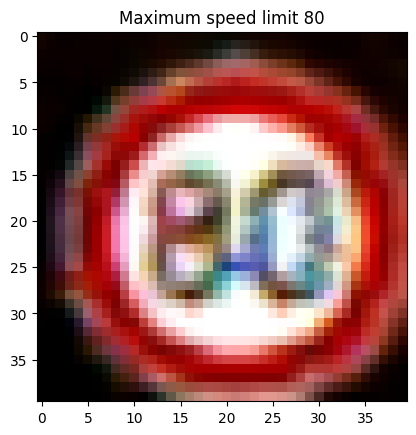

66 66


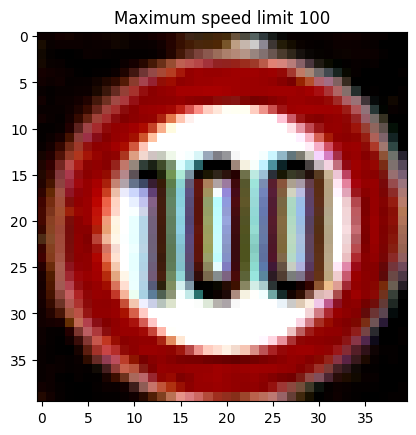

35 35


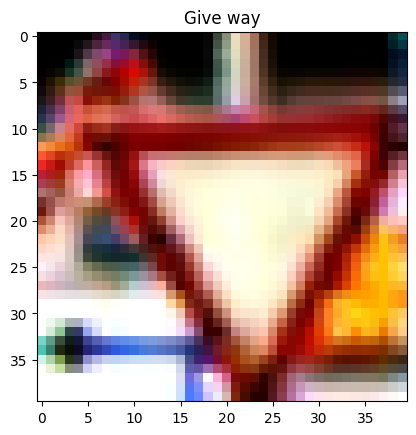

62 62


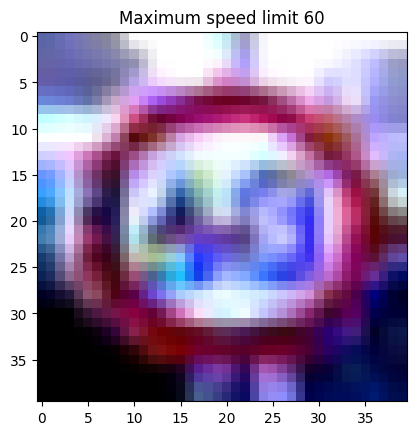

1 87


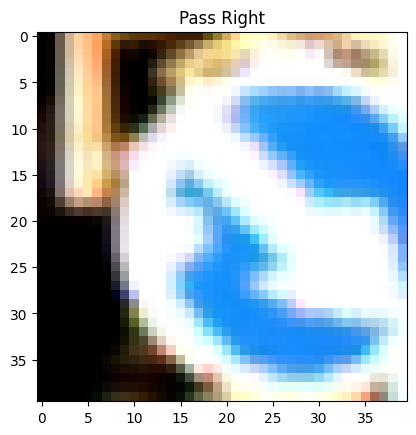

61 61


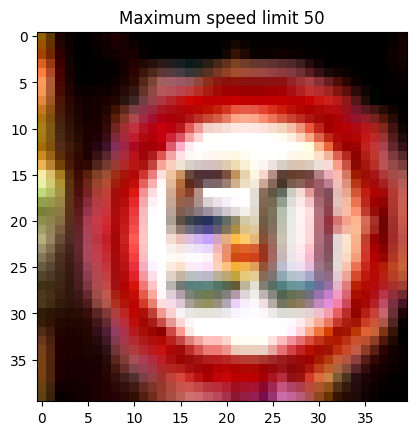

21 21


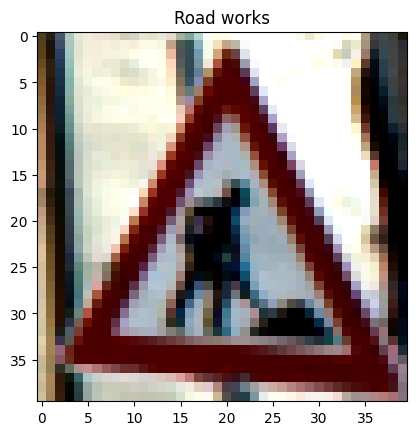

61 61


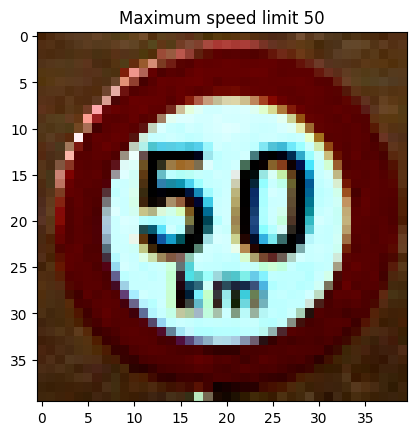

66 66


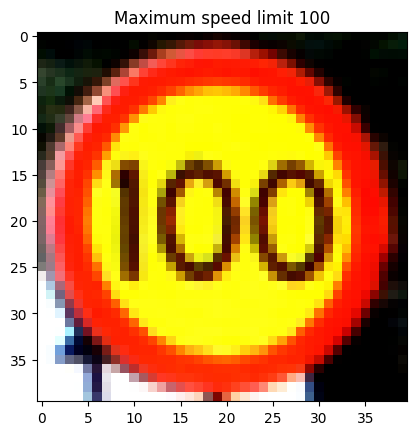

47 47


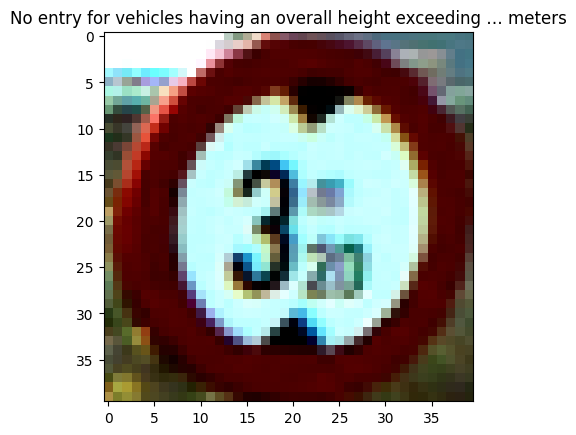

2 2


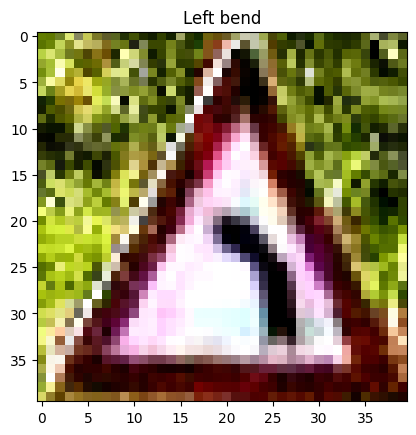

59 59


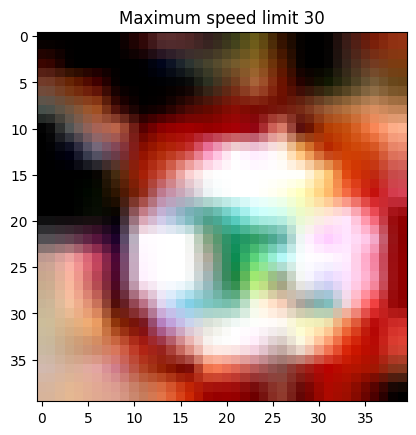

91 91


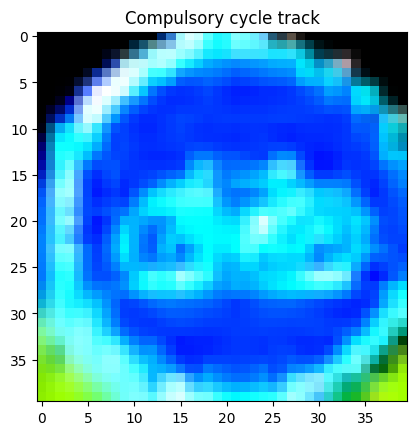

63 63


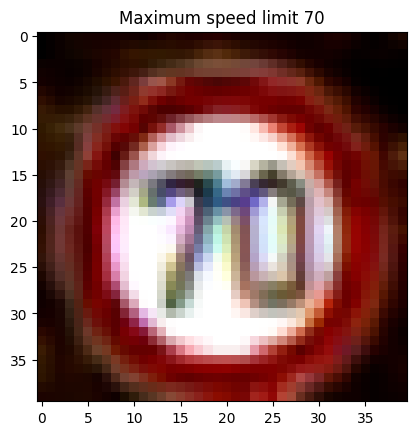

64 64


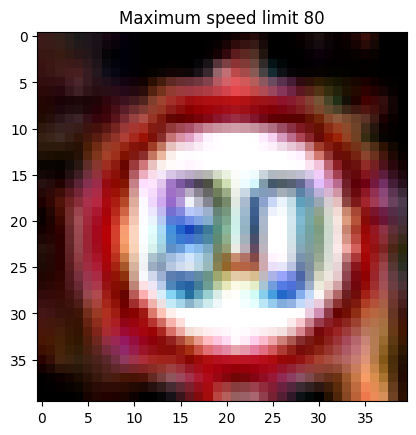

55 55


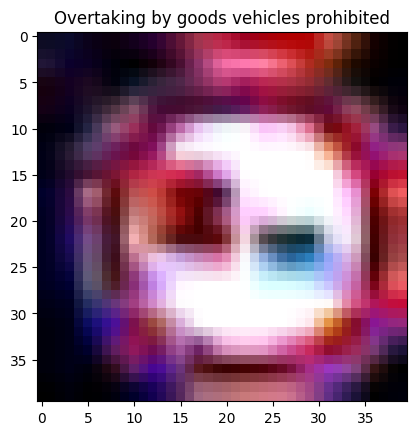

32 32


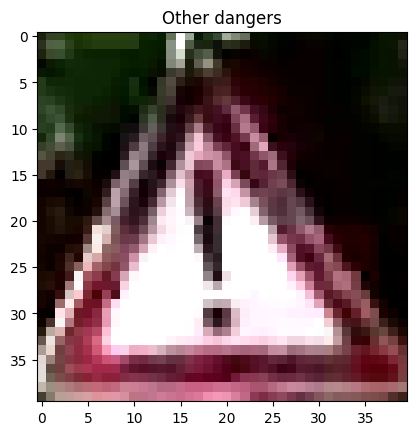

59 59


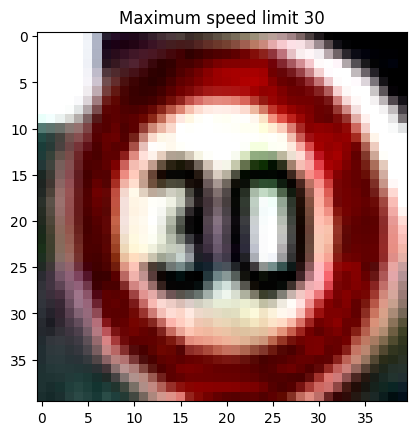

54 54


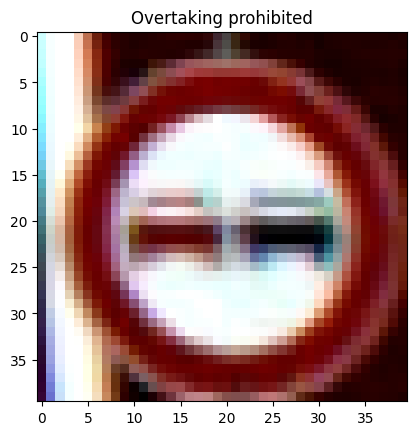

55 55


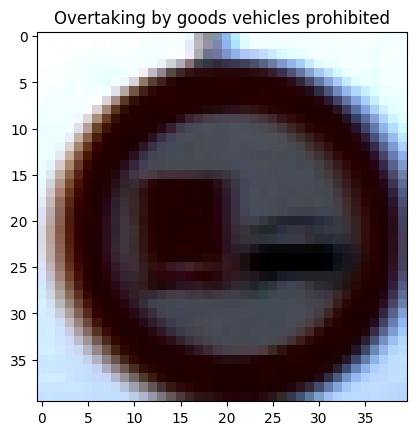

54 54


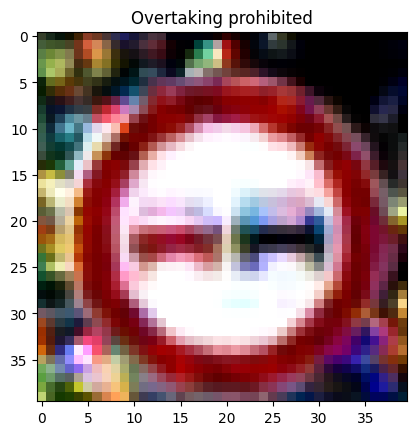

1 47


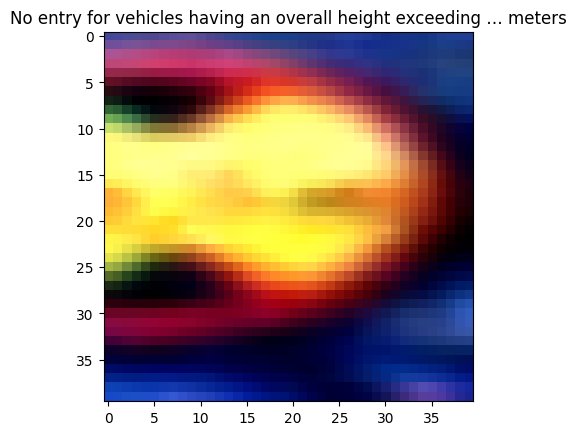

12 12


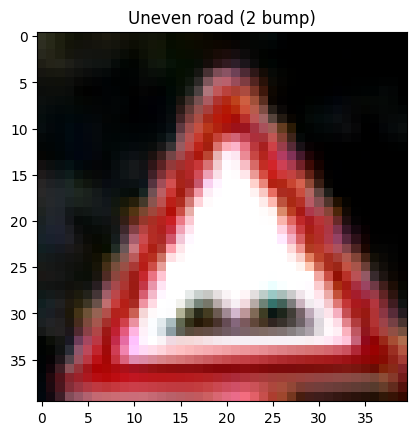

21 21


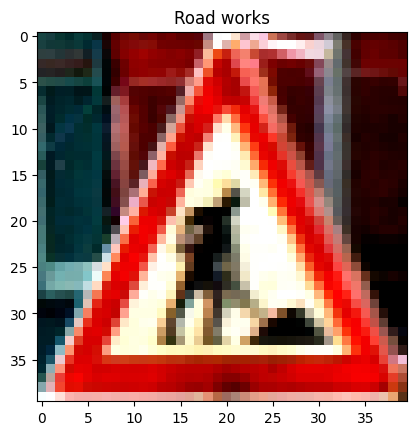

37 37


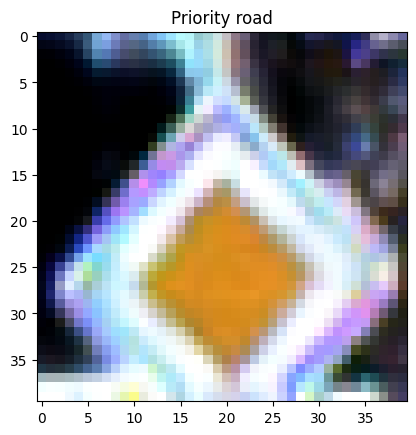

63 63


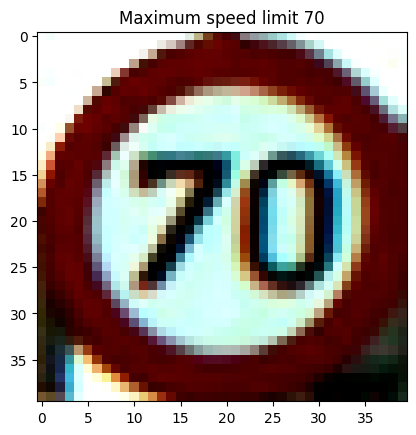

87 87


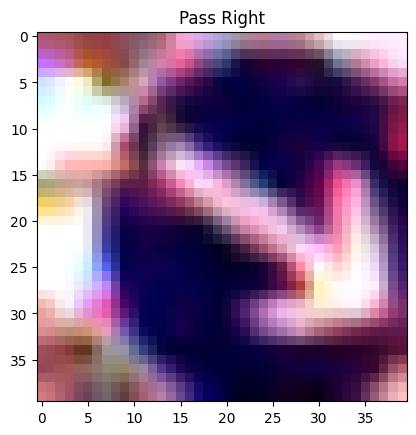

61 61


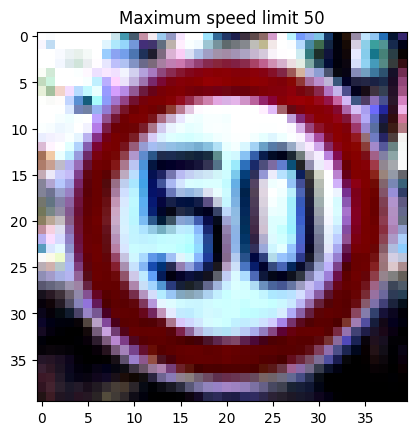

16 16


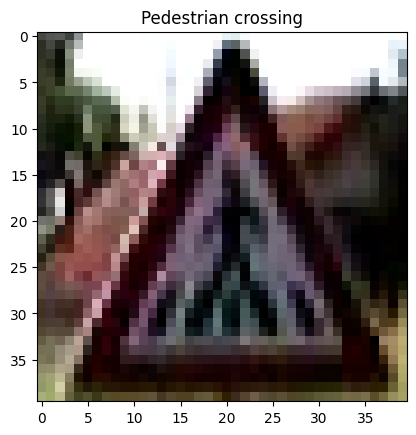

55 55


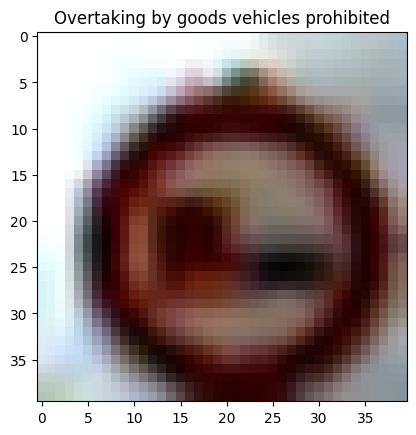

64 64


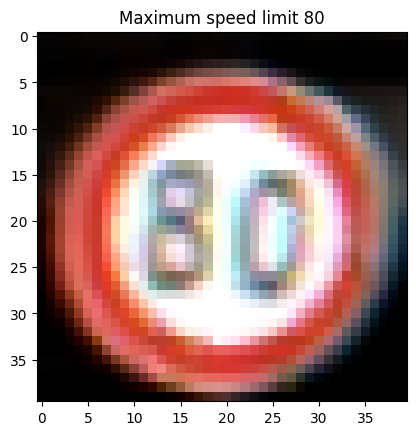

91 91


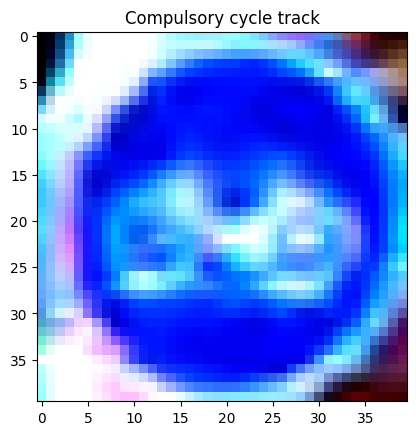

95 95


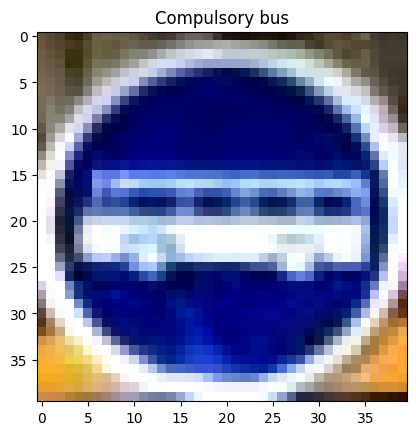

71 71


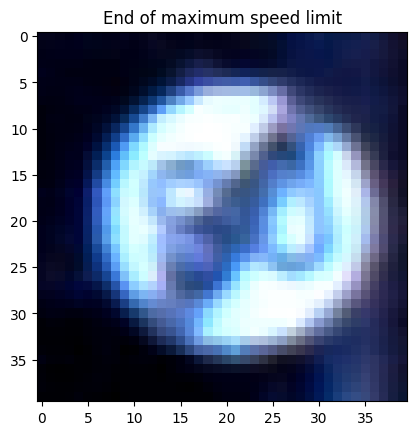

54 54


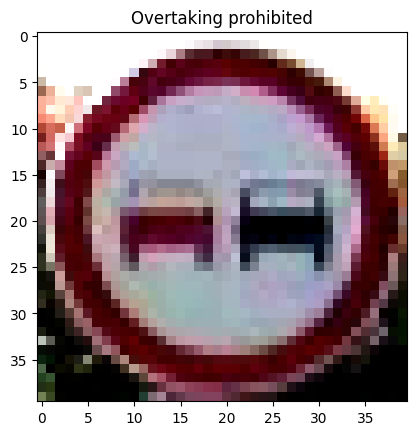

54 54


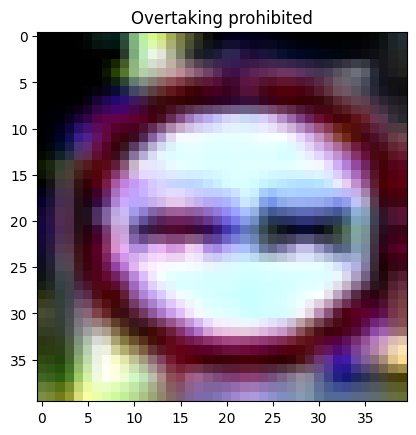

24 24


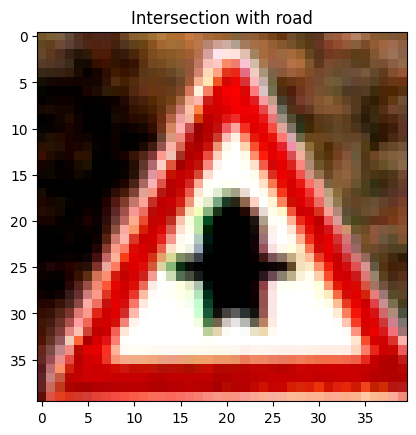

83 83


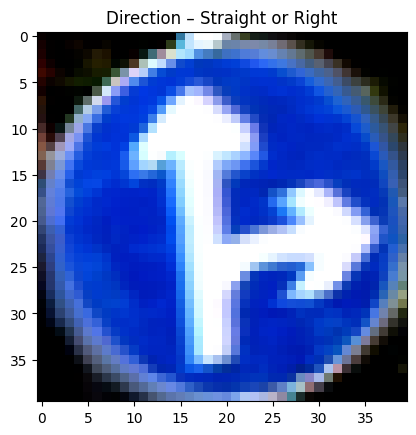

90 90


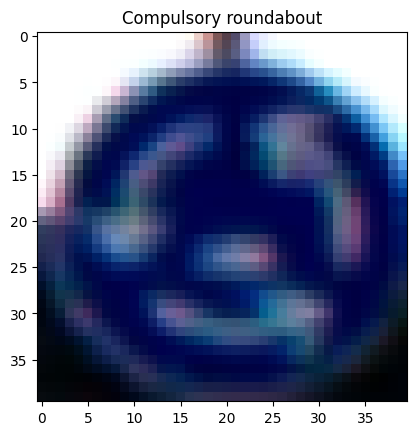

63 63


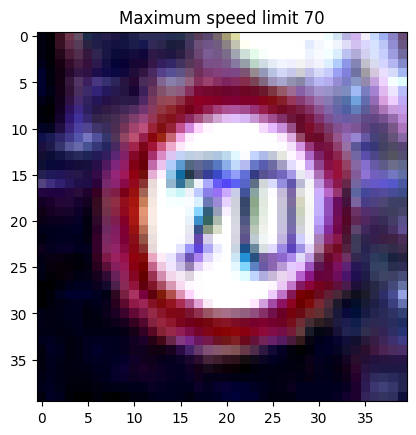

61 61


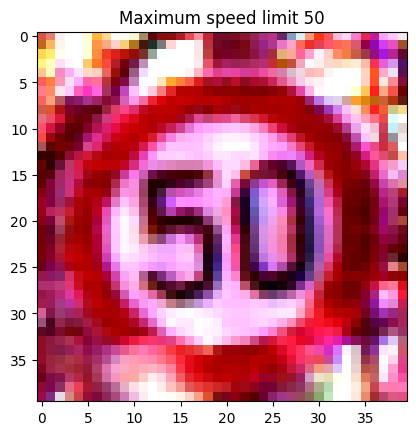

83 83


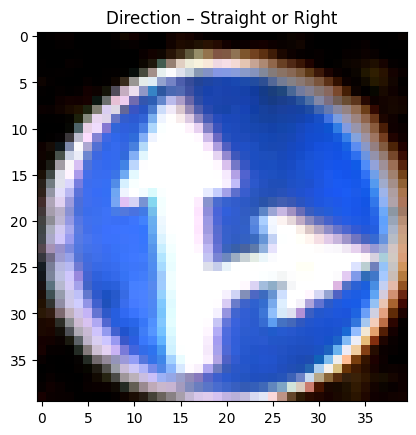

21 21


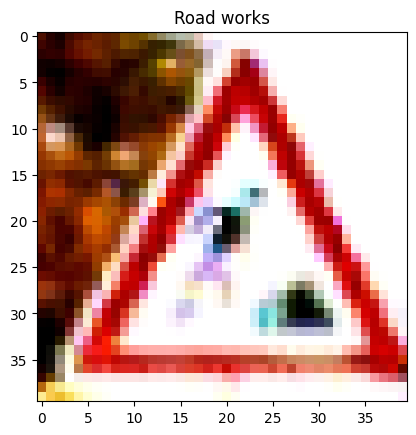

59 59


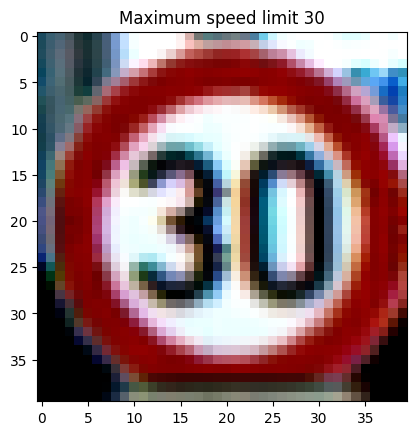

61 61


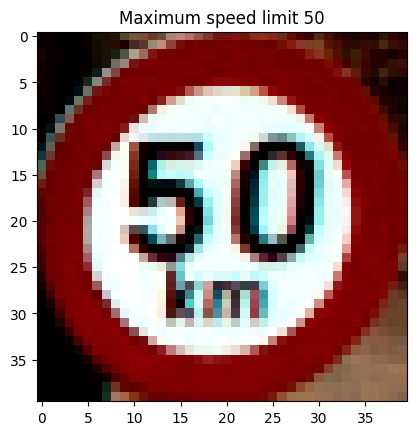

2 2


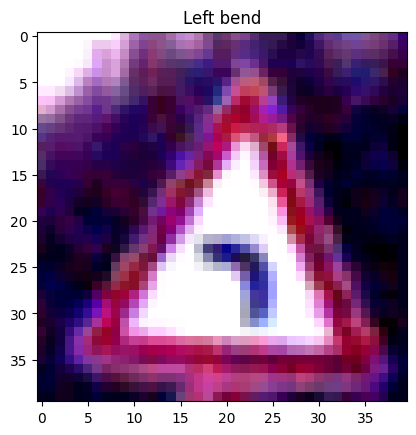

35 35


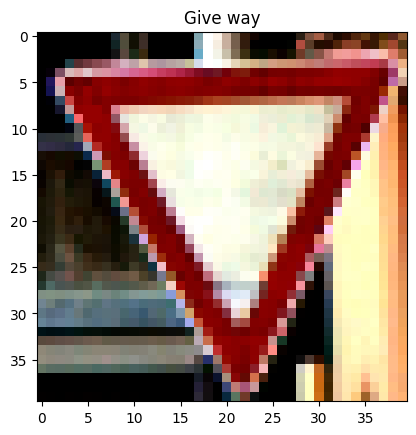

1 1


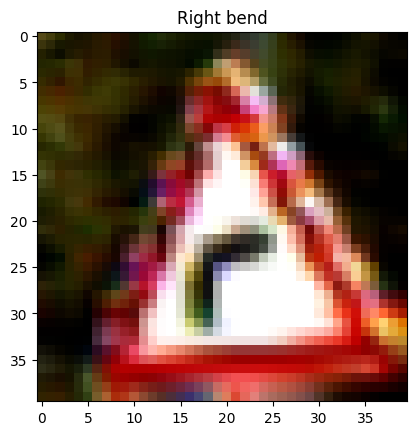

47 47


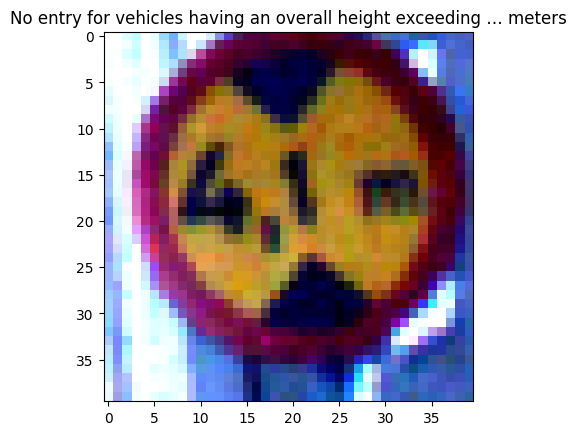

17 17


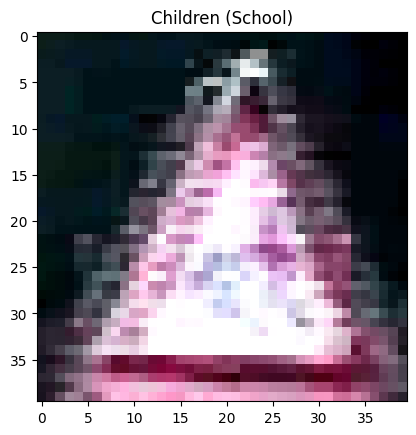

16 17


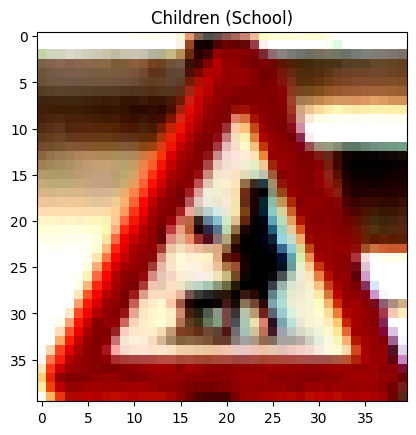

80 80


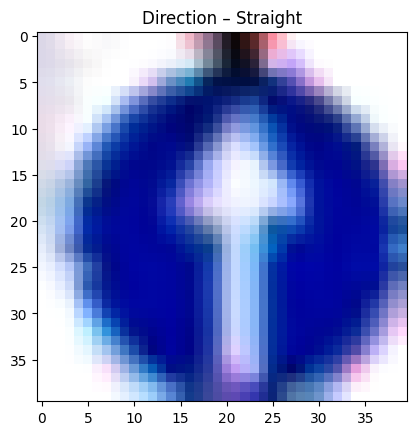

54 54


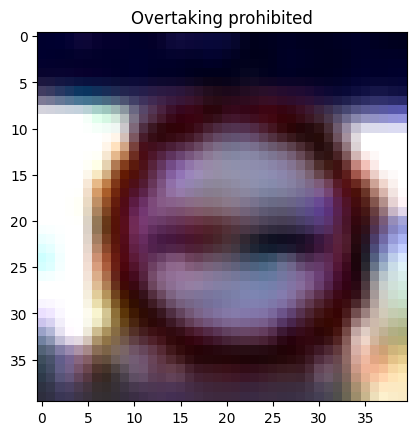

55 55


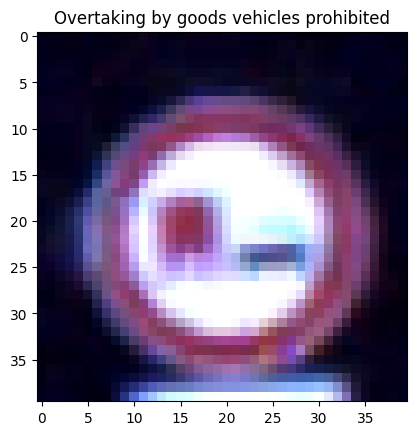

37 37


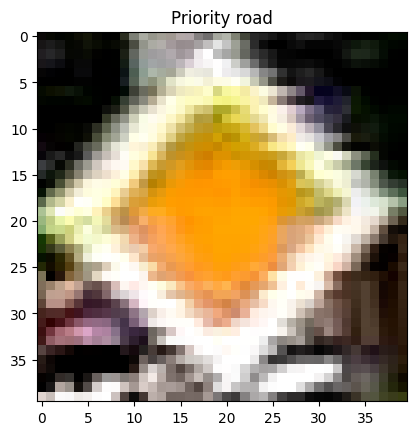

50 50


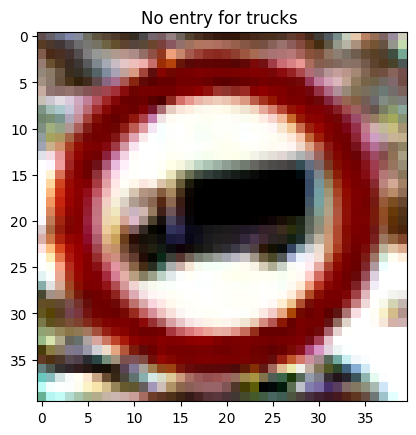

37 37


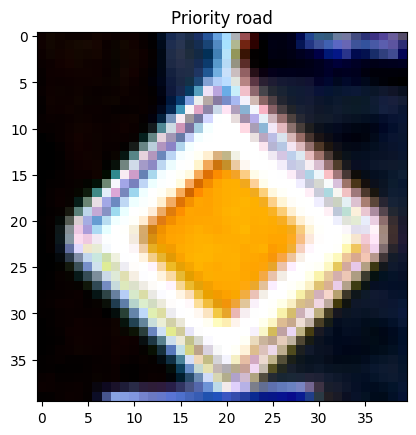

51 51


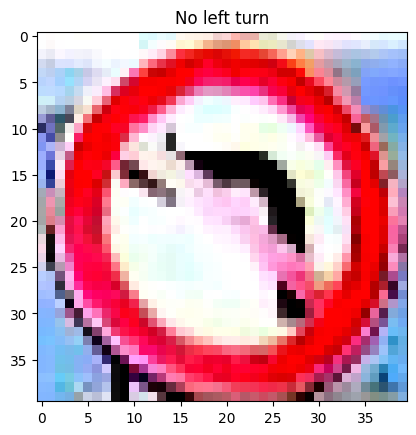

21 21


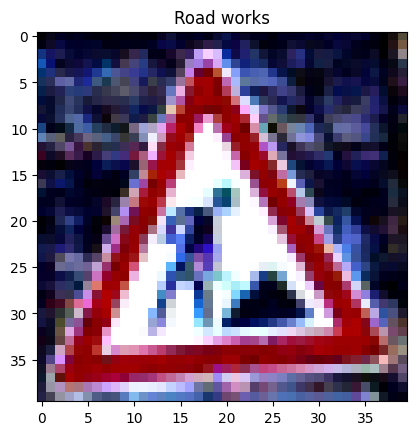

8 8


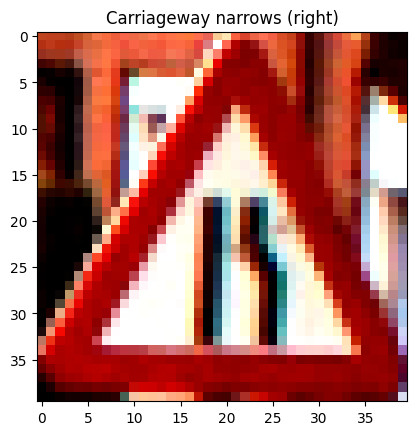

61 61


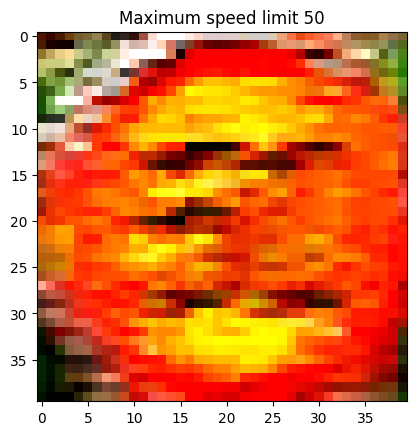

59 59


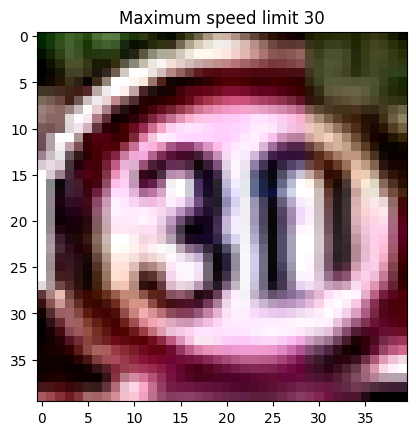

42 42


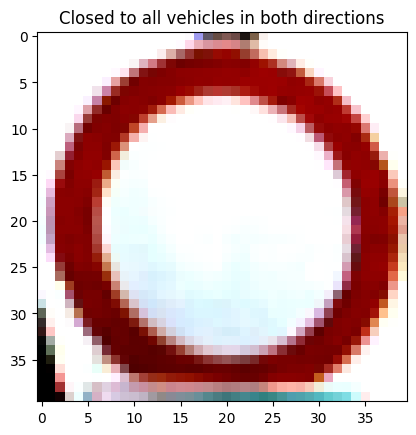

87 87


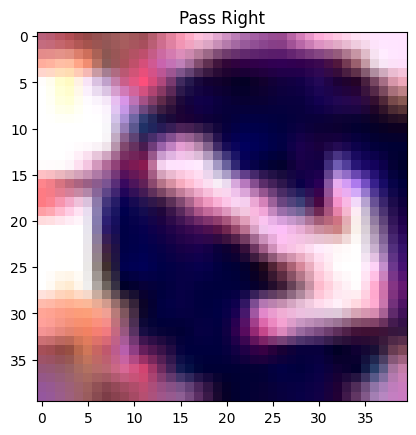

109 109


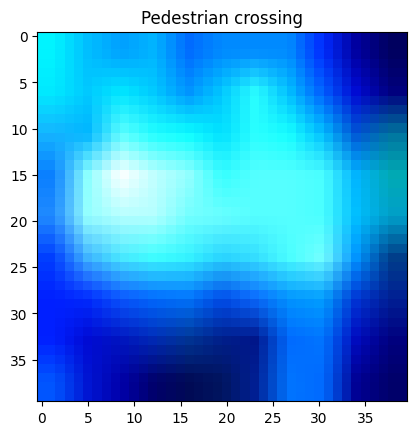

87 87


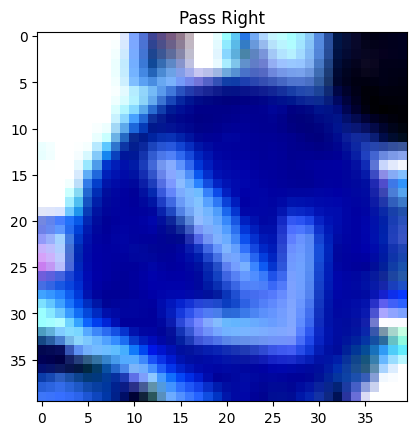

13 13


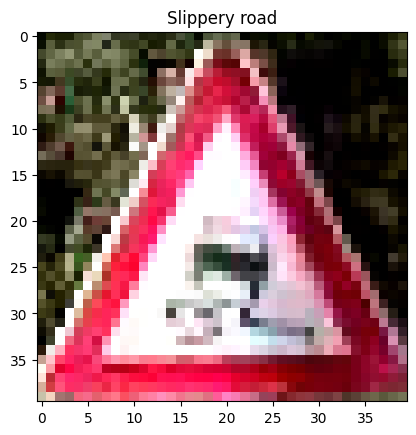

68 68


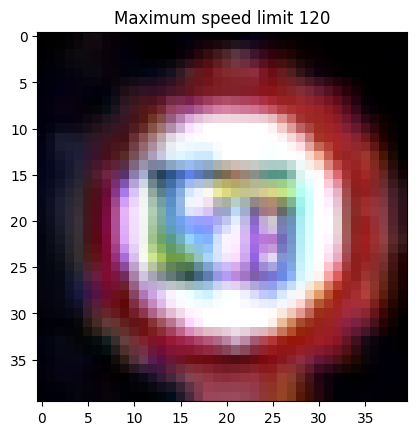

54 54


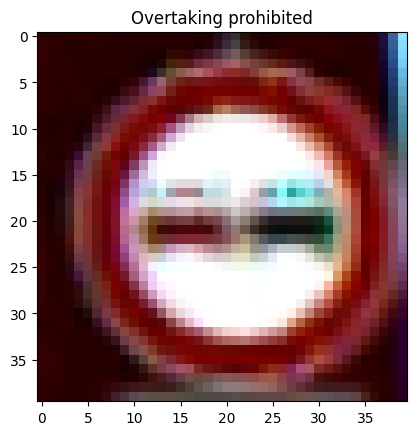

13 13


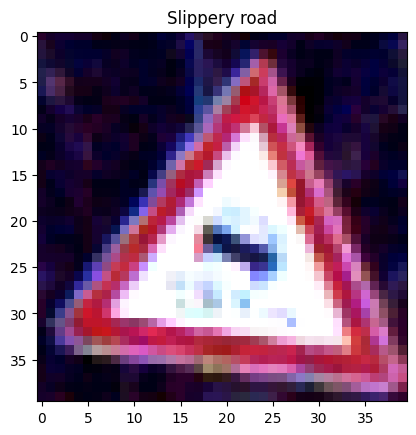

3 3


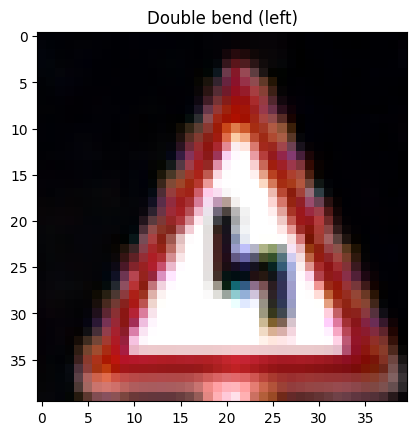

105 105


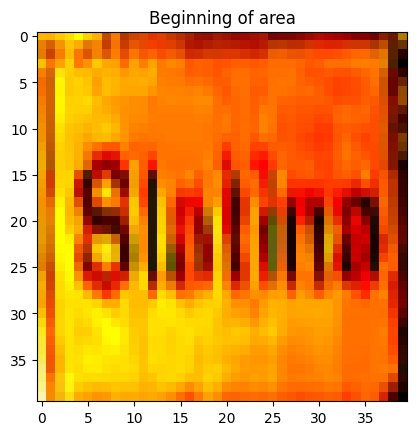

97 97


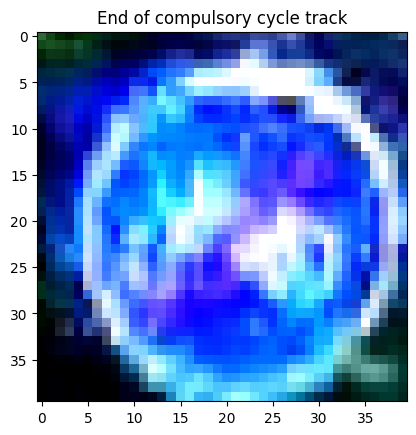

54 54


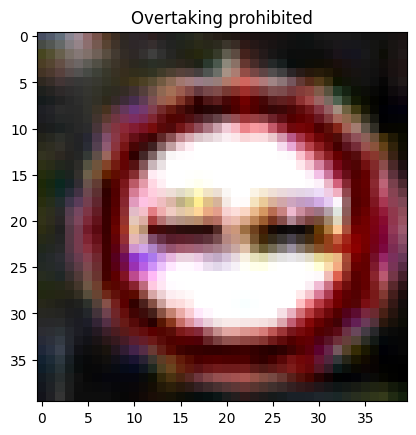

24 24


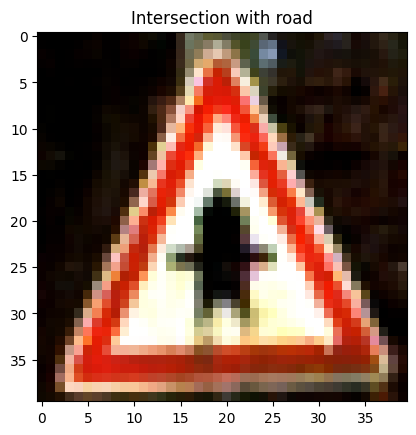

80 80


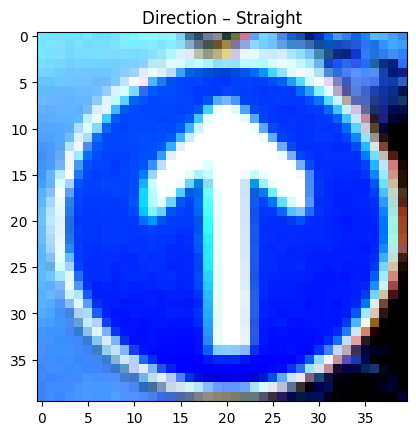

63 63


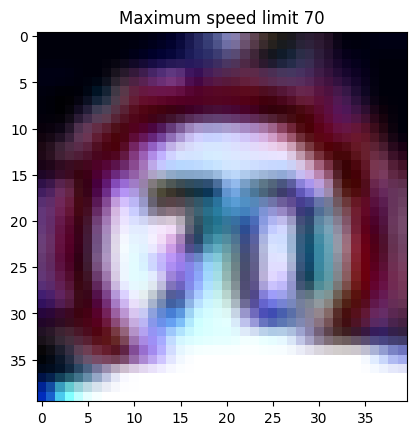

59 59


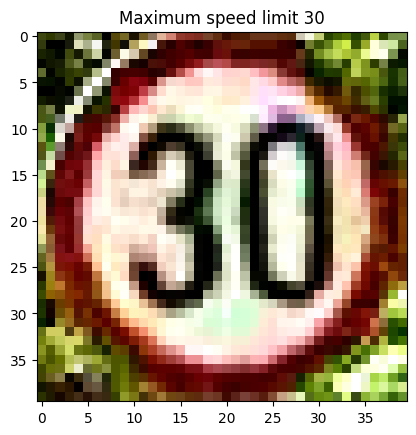

1 37


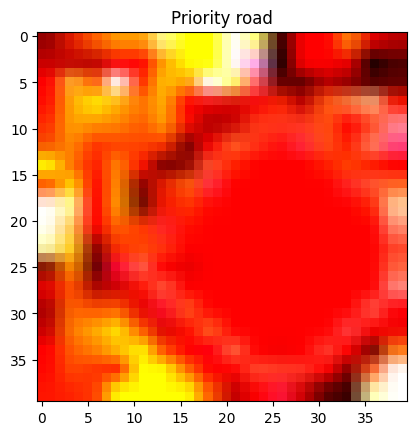

42 42


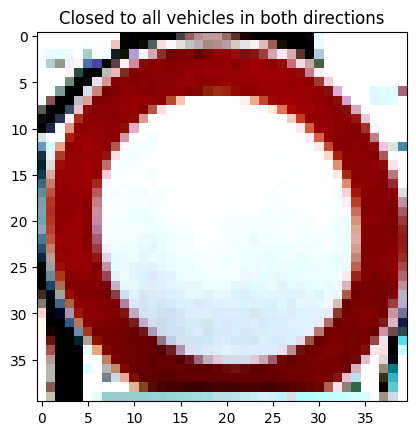

50 50


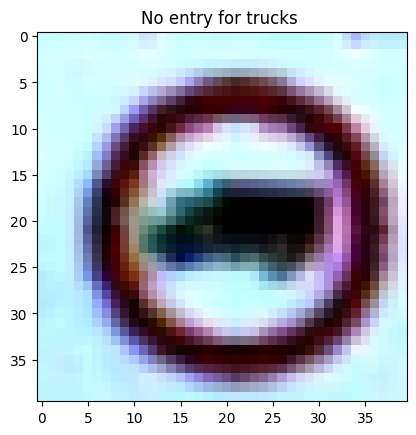

91 91


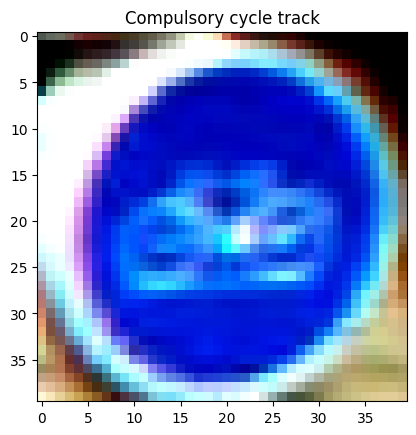

51 51


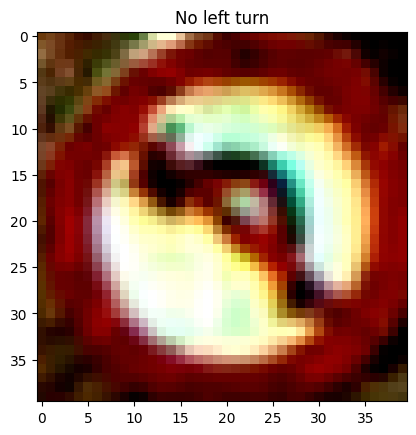

66 66


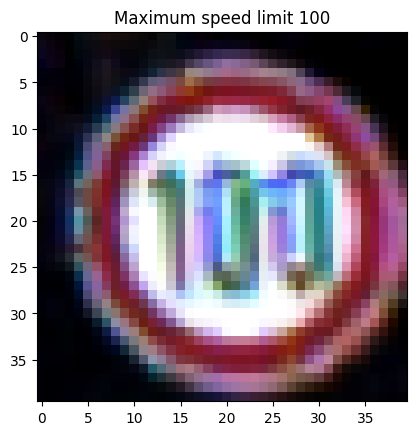

1 109


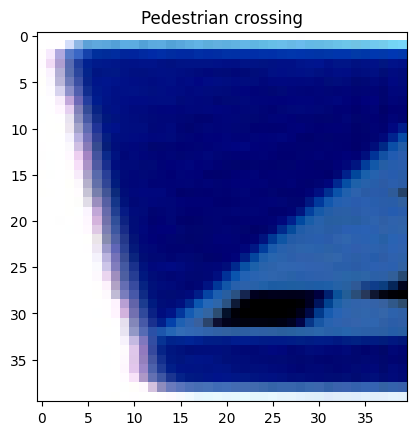

17 17


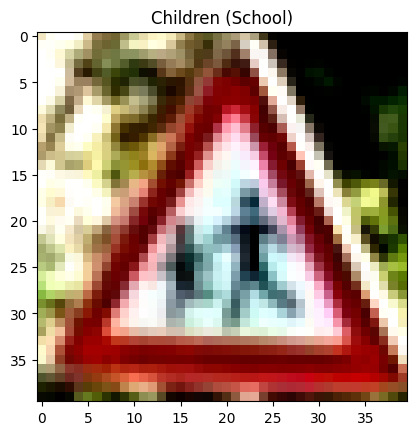

8 8


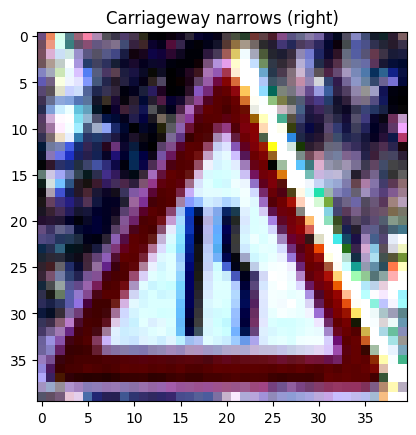

74 74


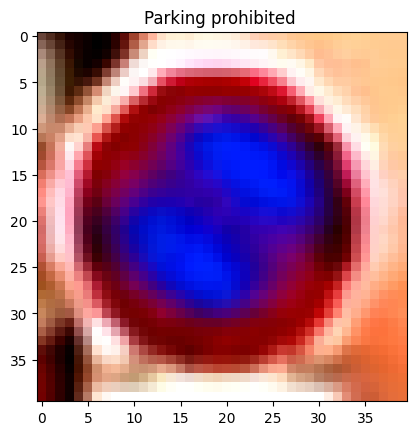

73 73


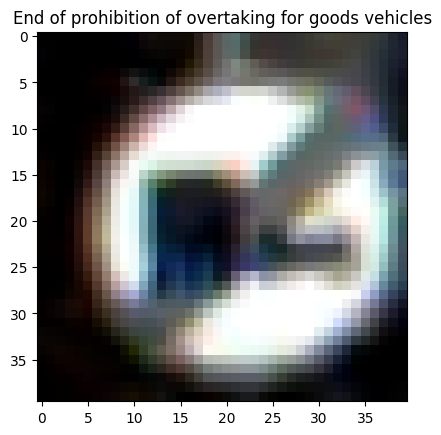

91 91


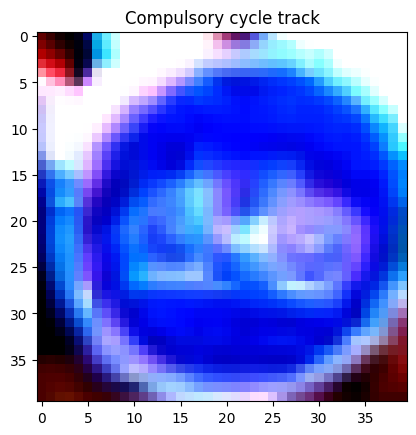

36 36


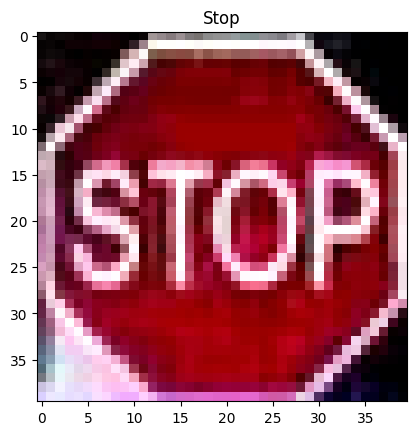

37 37


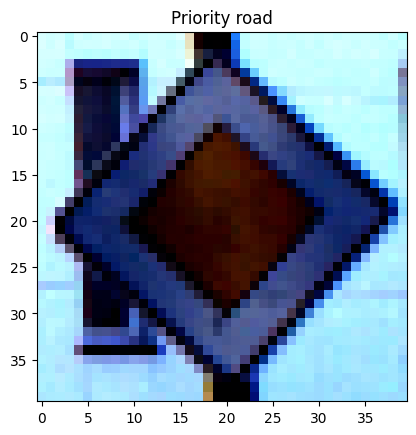

55 55


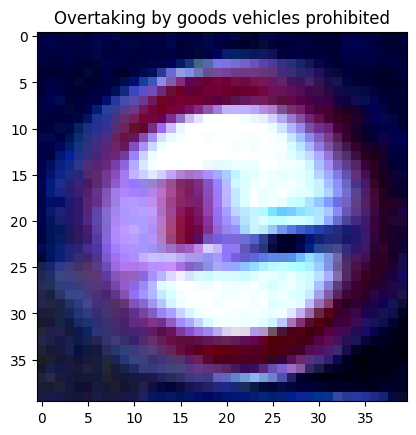

68 68


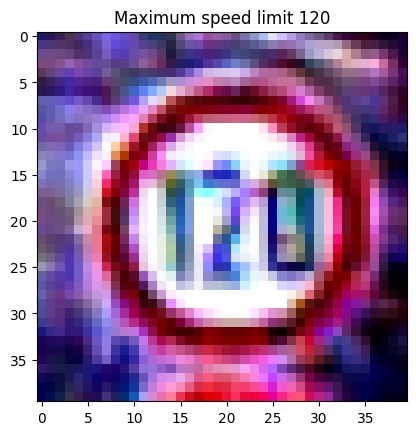

1 1


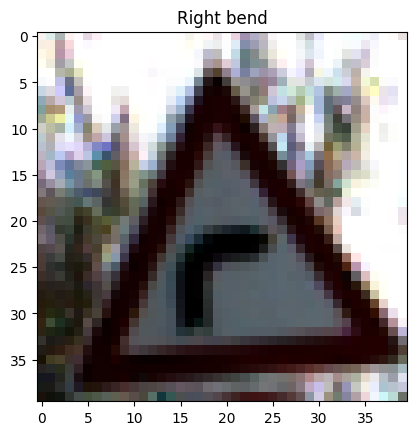

80 80


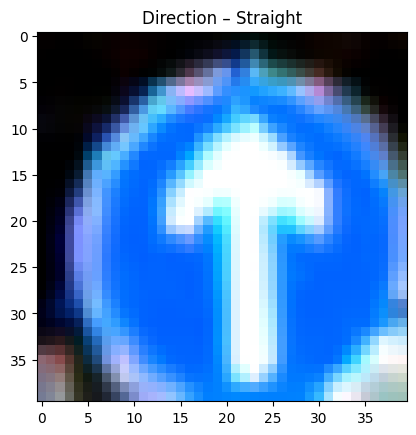

22 22


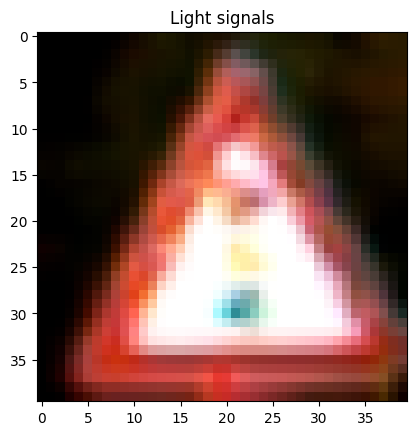

20 20


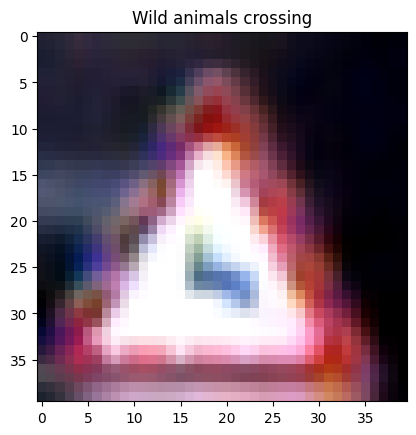

13 13


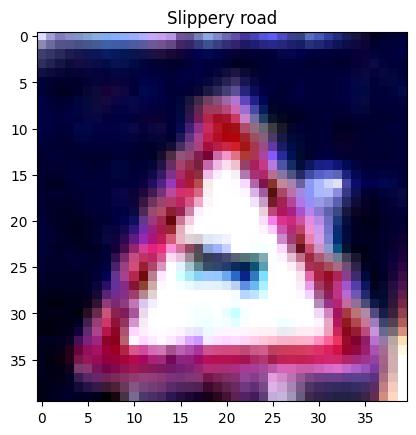

37 37


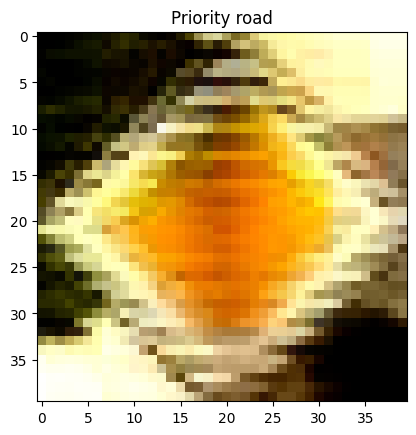

90 90


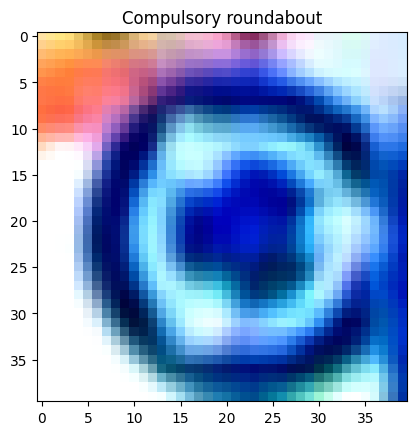

63 63


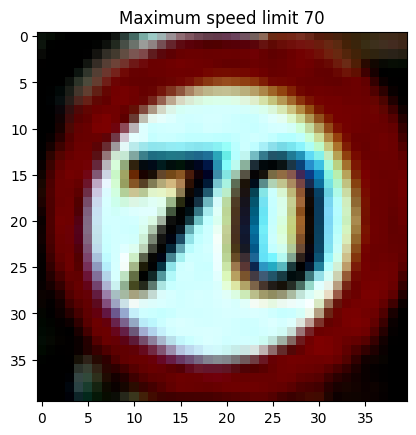

20 20


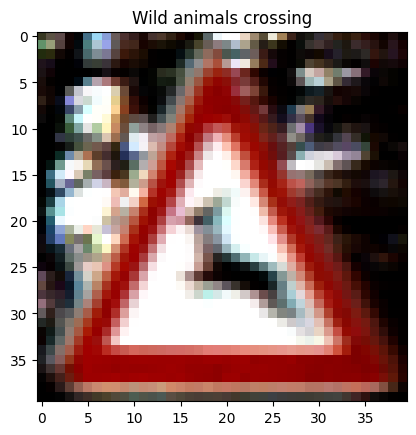

41 41


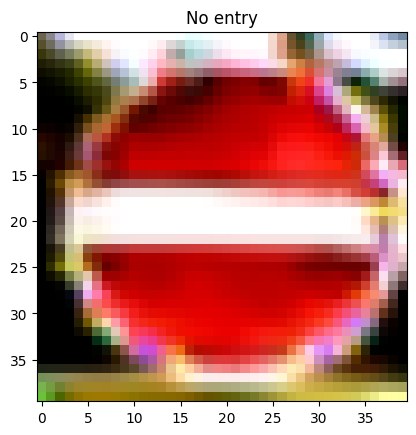

109 109


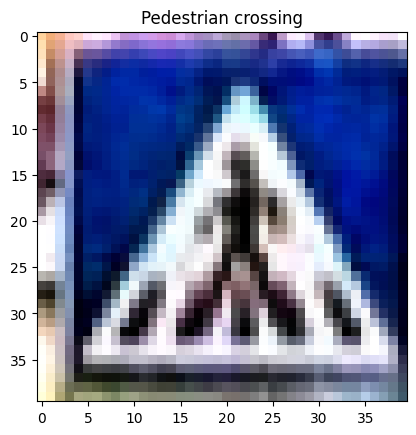

24 24


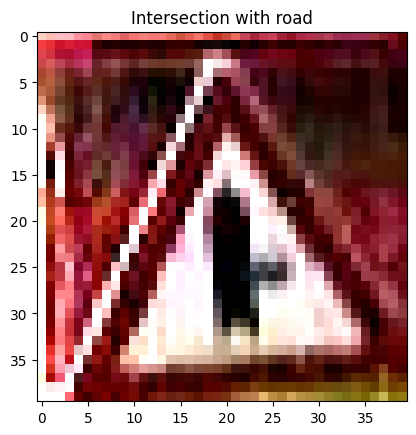

24 24


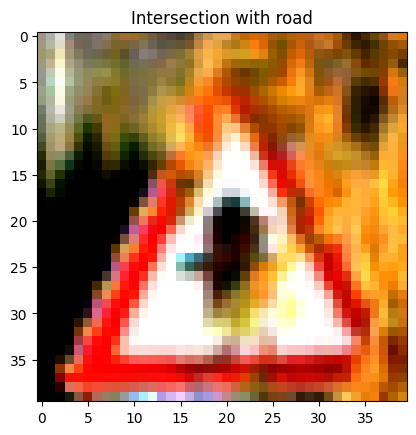

24 24


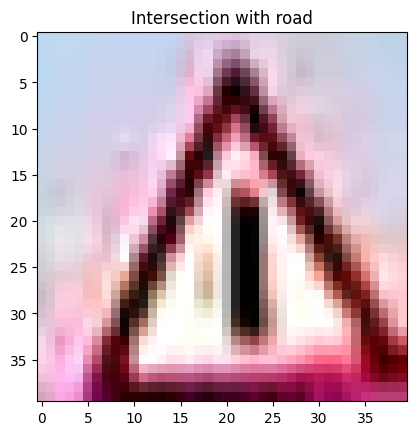

83 83


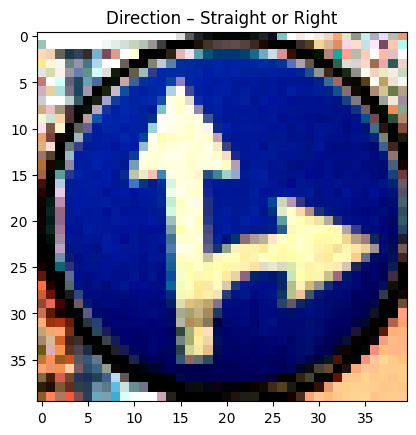

33 33


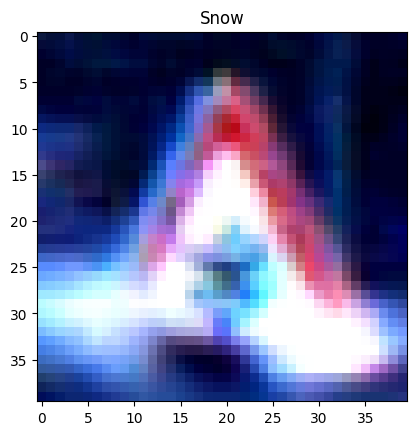

18 18


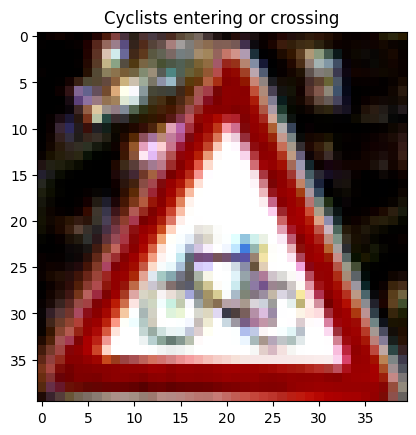

109 109


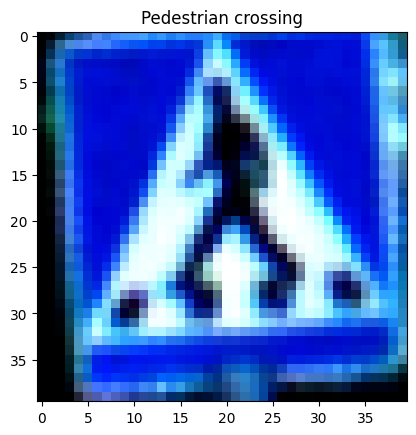

109 109


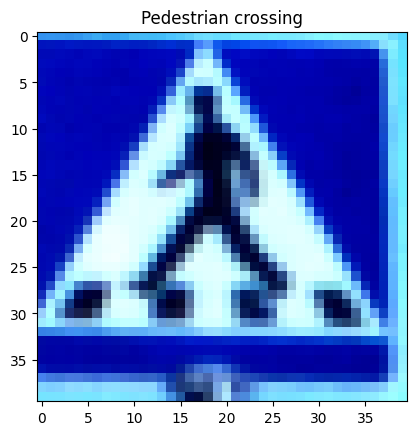

22 22


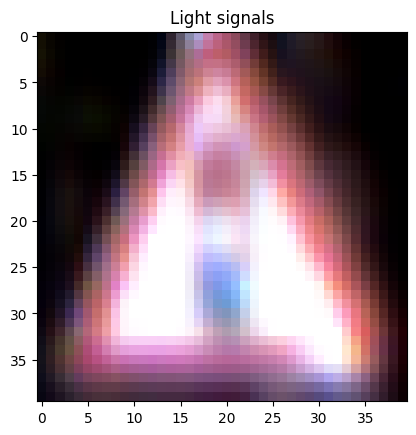

36 36


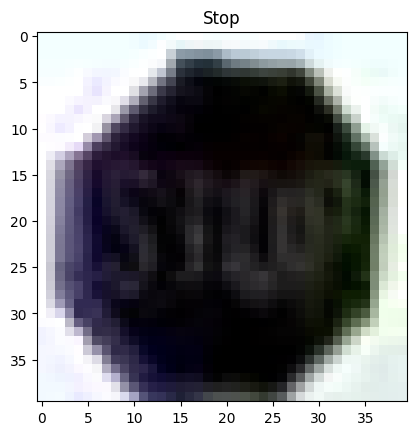

41 41


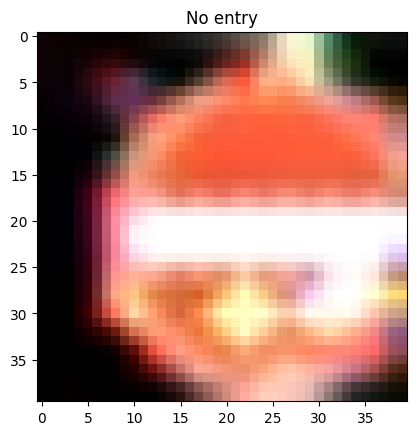

33 33


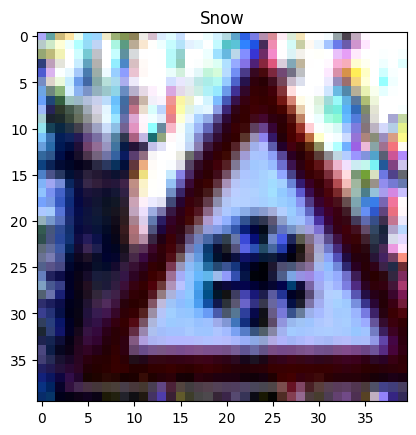

21 21


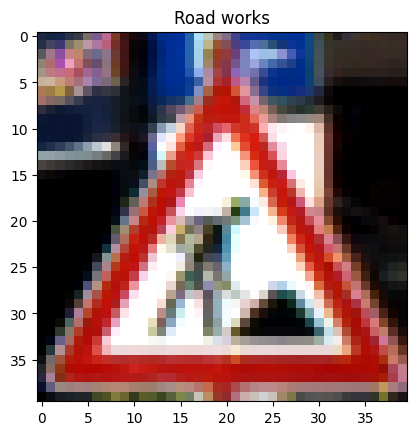

74 74


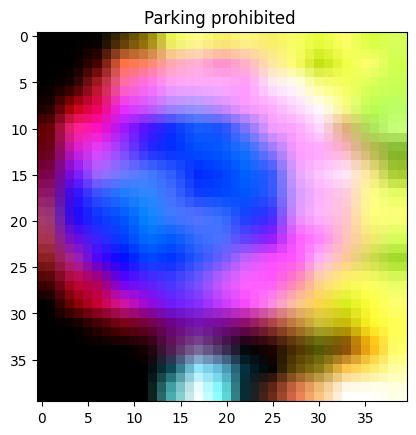

17 17


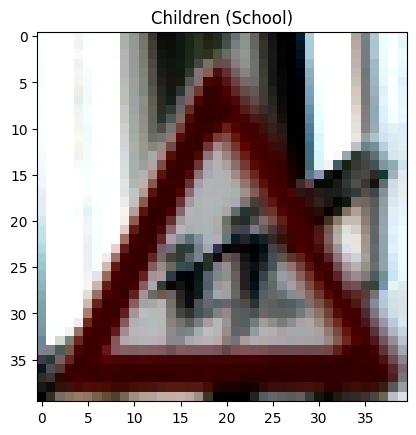

59 59


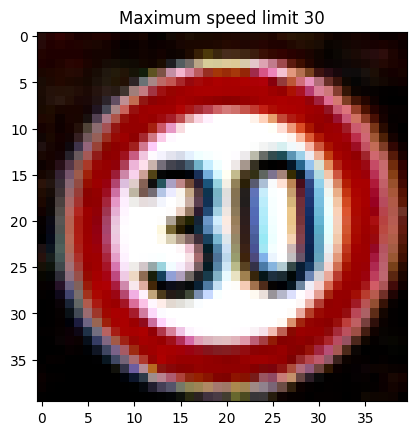

55 55


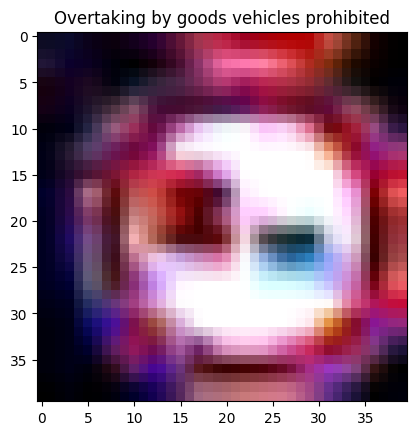

24 24


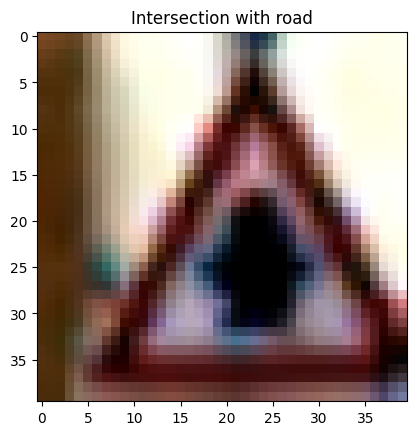

55 55


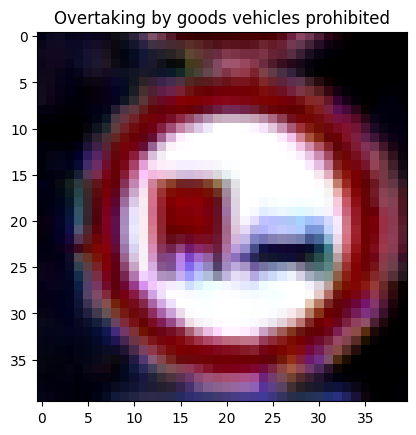

20 20


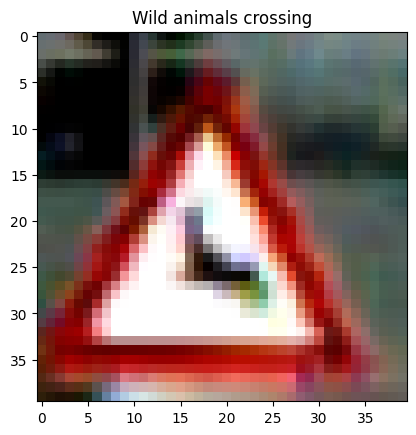

1 1


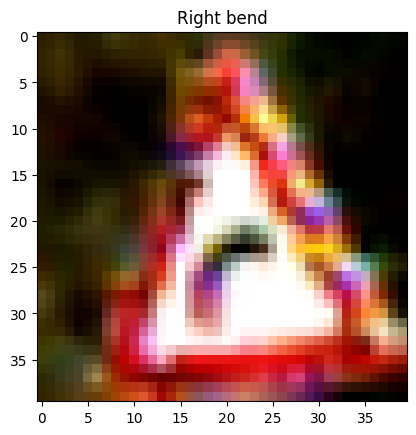

84 84


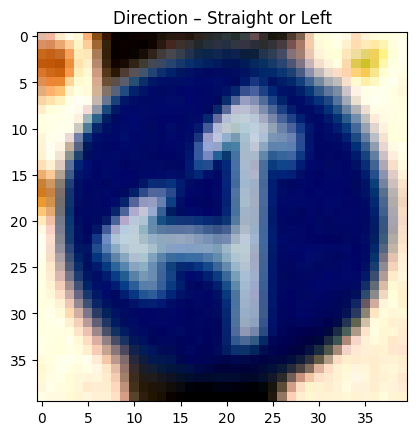

20 20


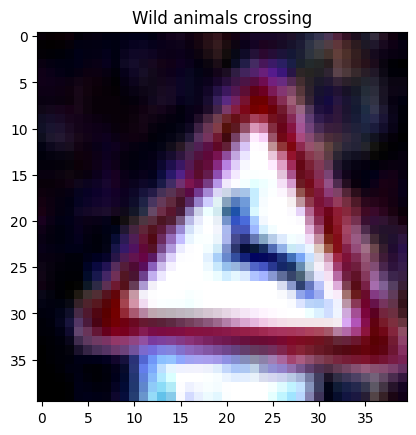

37 37


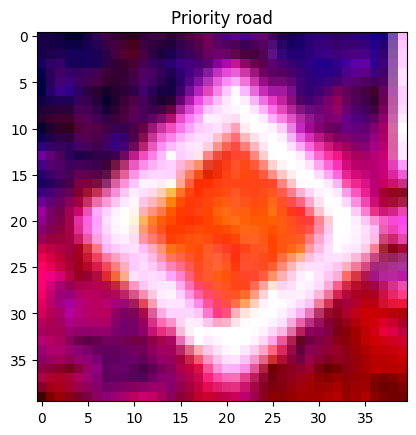

54 54


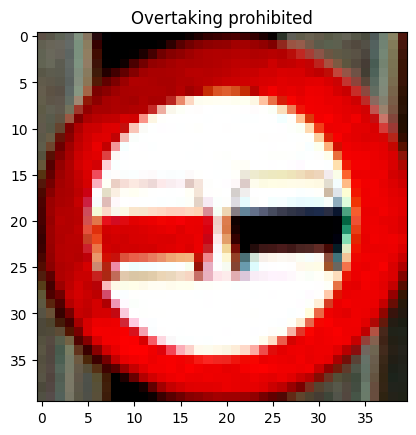

40 40


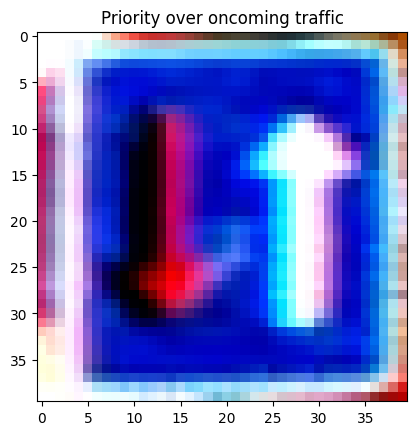

35 35


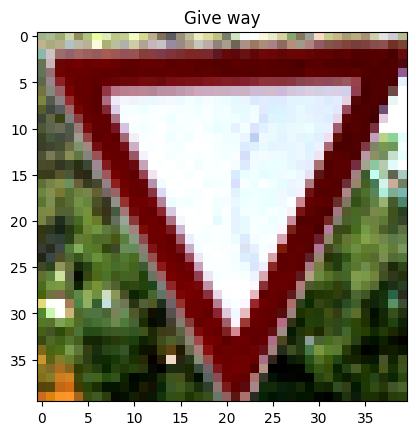

77 77


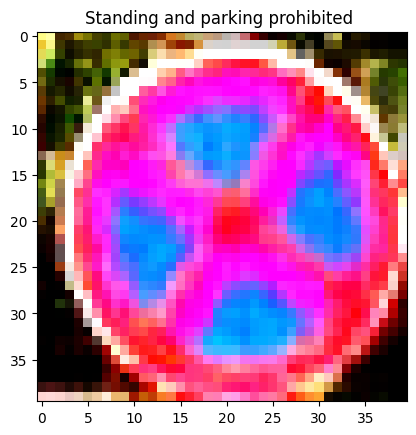

21 21


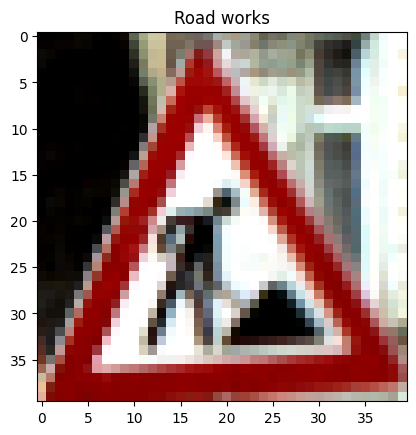

54 54


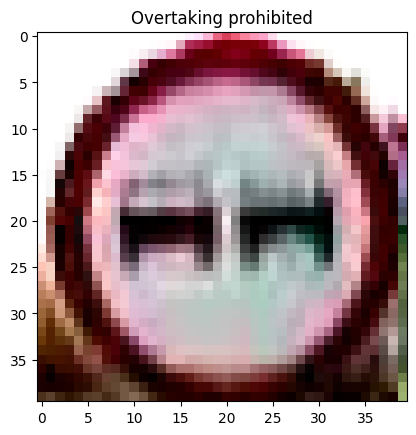

66 66


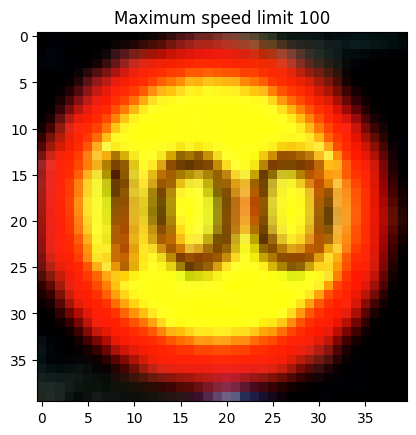

62 62


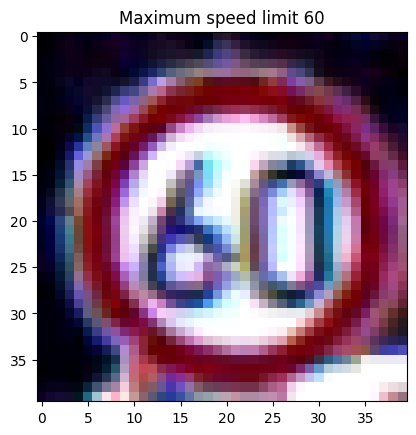

86 86


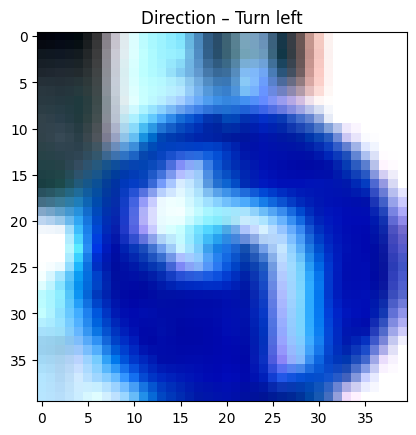

21 21


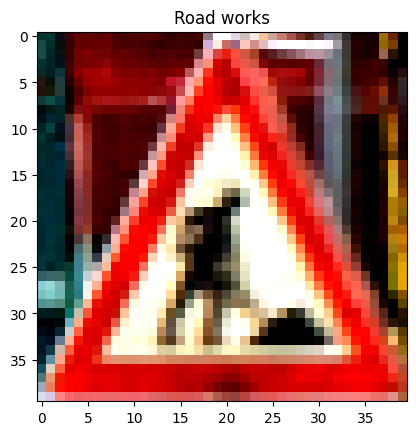

37 37


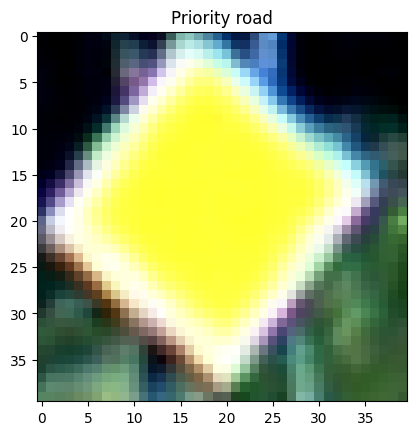

1 20


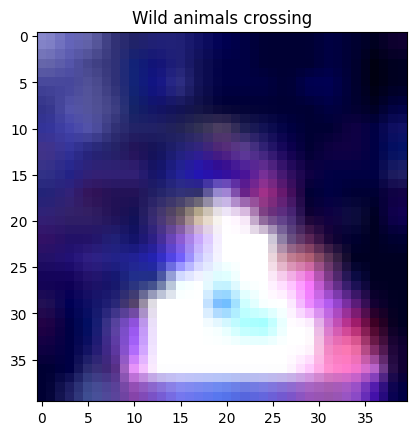

19 19


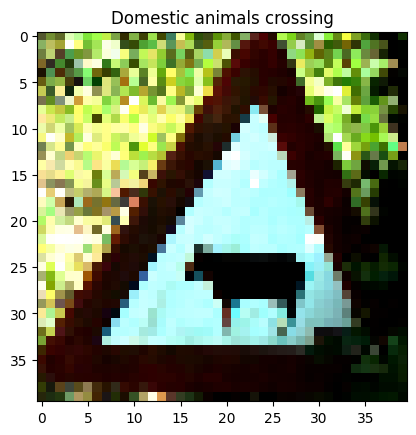

37 37


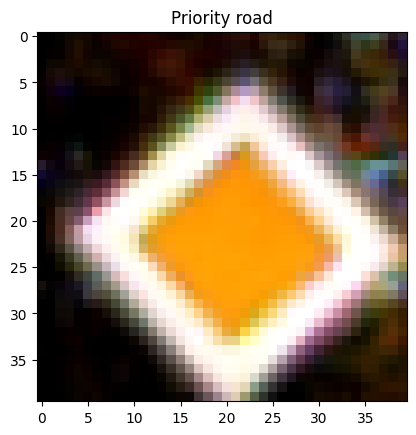

87 87


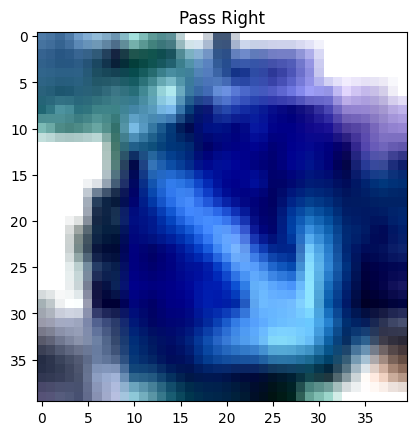

83 83


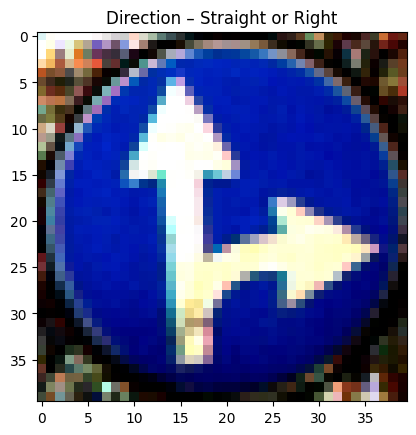

110 110


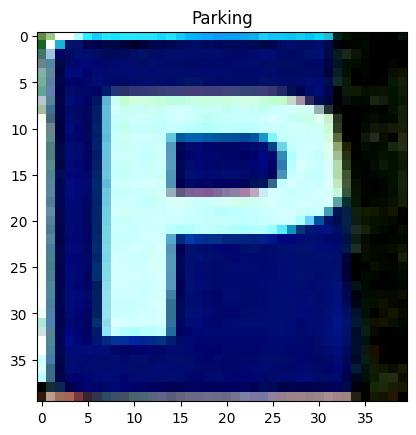

91 91


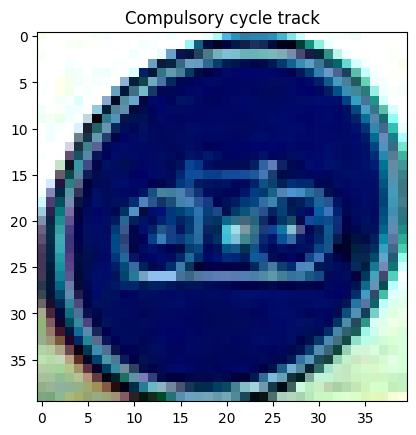

64 64


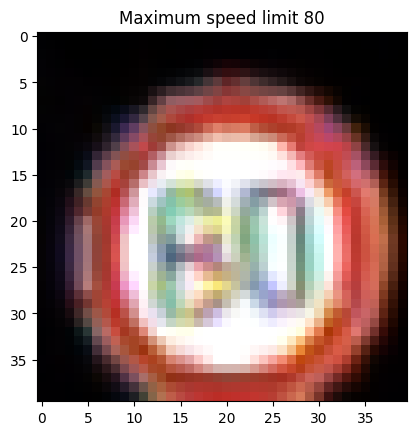

13 13


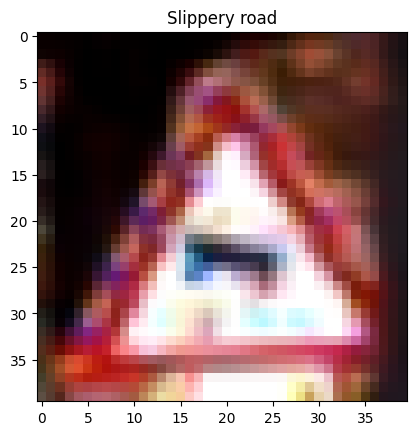

35 35


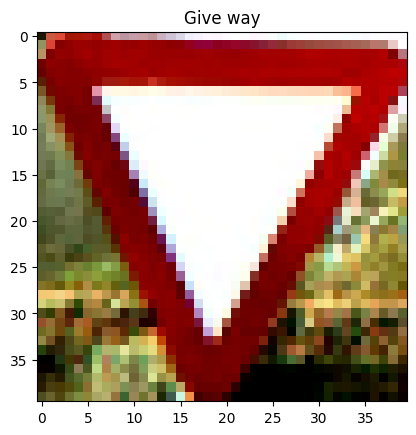

41 41


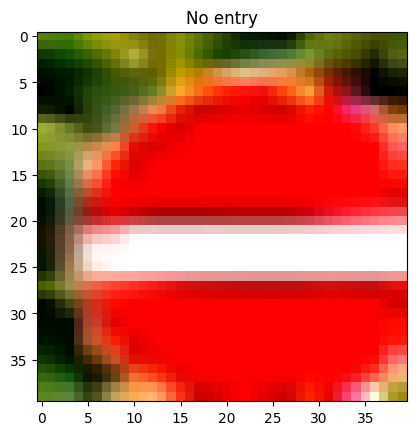

35 35


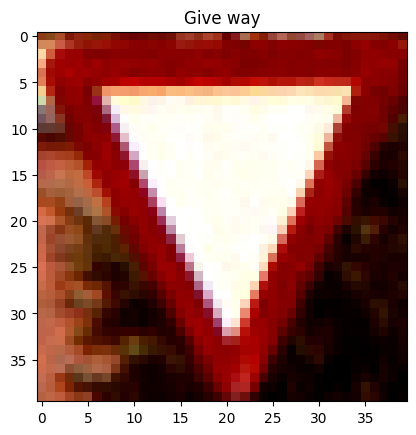

87 87


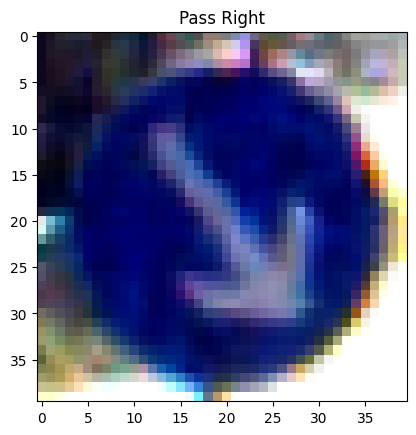

In [64]:
for i in random_numbers:
    image = test_images[i]
    image = np.float32(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(preds_recode[i],true_labels[i])
    plt.imshow(image)
    plt.title(classes.loc[classes['european_class'] == true_labels[i]].iloc[0].descriptive_name)
    plt.show()

In [67]:
cnn.save(name_out)

INFO:tensorflow:Assets written to: models/40_256_5_2_128_0.4_3_512_bg/assets


INFO:tensorflow:Assets written to: models/40_256_5_2_128_0.4_3_512_bg/assets
